# Case 3 mutation calling using several normal tissues and the parents

Case 3 samples:
- haplotypecaller
- mutect (tumor only mode)

Parents:
- haplotypecaller

And rescued mutations from bams

In [1]:
import os
import pandas as pd
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
tqdm.pandas()

In [2]:
samples = ['AQ5180','AQ5186','AQ5174','AX4954','AX4955','AX4956','AX4957','AX4962','AX4963','AX4964','AX4965','AX4966']
tissues = ['tumor1', 'tumor2', 'blood', 'kidney', 'liver', 'pancreas', 'heart','lung','medulla','spleen','brain','bma']
samples_dict = {samples[i]:tissues[i] for i in range(0,len(samples))}
suffixes_dict = {'tumor1':'_t1','tumor2':'_t2','blood':'_b','kidney':'_k','liver':'_l','pancreas':'_p','heart':'_h','lung':'_lu','medulla':'_me','spleen':'_s','brain':'_br','bma':'_bm'}

In [3]:
folder = './dictionaries/'
if not os.path.exists(folder):
    os.mkdir(folder)
    
with(open('dictionaries/suffixes_dict.json','w')) as f:
    json.dump(suffixes_dict,f)

In [4]:
%run ../../../wgs_analysis/tumor_vs_blood/vcf_postprocessing/python_scripts/aux_functions.py

## 1) Read and prepare parents' haplotypecaller files

In [6]:
#fix at the end
root_sarek = '/workspace/datasets/sjd_seq/sarek_results/pt1/results/'
# root_sarek = '/path/to/sarek/results/'
root_out = './output/'
if not os.path.exists(root_out):
    os.mkdir(root_out)

In [7]:
cols = ['#CHROM','POS','REF','ALT']
mother_df = read_vcf(root_sarek+'variant_calling/haplotypecaller/AW8063/AW8063.haplotypecaller.filtered.vcf.gz')
father_df = read_vcf(root_sarek+'variant_calling/haplotypecaller/AW8064/AW8064.haplotypecaller.filtered.vcf.gz')
parents_df = pd.merge (mother_df[cols],father_df[cols],how='outer',indicator=True)
parents_df

,#CHROM,POS,REF,ALT,_merge
0,chr1,10397,CCCCTAA,C,left_only
1,chr1,10492,C,T,left_only
2,chr1,10904,G,A,left_only
3,chr1,10927,A,G,left_only
4,chr1,13613,T,A,left_only
...,...,...,...,...,...
6801495,chrY,56886107,C,CAAAAAAAAAACTT,right_only
6801496,chrY,56887111,A,AGTTGTT,right_only
6801497,chrY,56887139,GT,G,right_only
6801498,chrY,56887491,C,A,right_only


In [8]:
parents_df = parents_df.replace('left_only','mother')
parents_df = parents_df.replace('right_only','father')
parents_df.groupby('_merge').count()

,#CHROM,POS,REF,ALT
_merge,,,,
mother,1889463,1889463,1889463,1889463
father,1836372,1836372,1836372,1836372
both,3075665,3075665,3075665,3075665


In [9]:
parents_df = parents_df.rename(columns={'#CHROM':'CHROM'})

In [10]:
comma1_df = parents_df[parents_df['ALT'].str.contains(',')]
comma2_df = comma1_df.copy()
comma1_df['alt_original'] = comma1_df['ALT']
comma1_df['ALT'] = comma1_df['alt_original'].str.split(',',expand=True)[0]
comma2_df['alt_original'] = comma2_df['ALT']
comma2_df['ALT'] = comma2_df['alt_original'].str.split(',',expand=True)[1]
comma_df = pd.concat([comma1_df,comma2_df],ignore_index=True)
non_comma_df = parents_df[~parents_df['ALT'].str.contains(',')]
parents2_df = pd.concat([non_comma_df,comma_df],ignore_index=True)
parents2_df.drop('alt_original',axis=1,inplace=True)
parents2_df.sort_values(['CHROM','POS'],ascending=True,inplace=True)
parents2_df = parents2_df.reset_index()
parents2_df.drop('index',inplace=True,axis=1)
parents2_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CHROM,POS,REF,ALT,_merge
0,chr1,10397,CCCCTAA,C,mother
1,chr1,10492,C,T,mother
2,chr1,10904,G,A,mother
3,chr1,10927,A,G,mother
4,chr1,13079,C,G,father
...,...,...,...,...,...
6958032,chrY,56887228,T,C,both
6958033,chrY,56887316,G,A,mother
6958034,chrY,56887463,C,A,both
6958035,chrY,56887491,C,A,father


In [11]:
#remove spanning deletions
parents3_df = parents2_df[parents2_df['ALT']!='*']
parents3_df

,CHROM,POS,REF,ALT,_merge
0,chr1,10397,CCCCTAA,C,mother
1,chr1,10492,C,T,mother
2,chr1,10904,G,A,mother
3,chr1,10927,A,G,mother
4,chr1,13079,C,G,father
...,...,...,...,...,...
6958032,chrY,56887228,T,C,both
6958033,chrY,56887316,G,A,mother
6958034,chrY,56887463,C,A,both
6958035,chrY,56887491,C,A,father


In [12]:
parents3_df['ref_original'] = parents3_df['REF']
parents3_df['alt_original'] = parents3_df['ALT']
parents3_df['pos_original'] = parents3_df['POS']
parents3_df = parents3_df.progress_apply(lambda row: fix_indels(row),axis=1)
parents3_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,CHROM,POS,REF,ALT,_merge,ref_original,alt_original,pos_original
0,chr1,10398,CCCTAA,-,mother,CCCCTAA,C,10397
1,chr1,10492,C,T,mother,C,T,10492
2,chr1,10904,G,A,mother,G,A,10904
3,chr1,10927,A,G,mother,A,G,10927
4,chr1,13079,C,G,father,C,G,13079
...,...,...,...,...,...,...,...,...
6958032,chrY,56887228,T,C,both,T,C,56887228
6958033,chrY,56887316,G,A,mother,G,A,56887316
6958034,chrY,56887463,C,A,both,C,A,56887463
6958035,chrY,56887491,C,A,father,C,A,56887491


In [13]:
#remove _merge column
parents3_df.drop('_merge',axis=1,inplace=True)

In [14]:
print(len(parents3_df),'muts')
parents3_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(parents3_df),'muts after drop_duplicates')

6929537 muts
6871682 muts after drop_duplicates


## 2) Read and prepare tumors and tissues haplotypecaller tables

In [17]:
#this is the chunk code for the test (using root_sarek and root_hmf_pipeline) -> fix at the end
#fix at the end
root_hmf_pipeline1 = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t1-allsamples-t1/sarek_results/results/'
root_hmf_pipeline2 = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t2-allsamples-t2/sarek_results/results/'

print('Reading tumor1 file...')
tumor1_df = read_vcf(root_hmf_pipeline1+'variant_calling/haplotypecaller/AQ5180/AQ5180.haplotypecaller.filtered.vcf.gz')
print('Reading tumor2 file...')
tumor2_df = read_vcf(root_hmf_pipeline2+'variant_calling/haplotypecaller/AQ5186/AQ5186.haplotypecaller.filtered.vcf.gz')
print('Merging files...')
hc_df = pd.merge(tumor1_df[cols],tumor2_df[cols],how='outer',indicator='tumor1')
hc_df['tumor2'] = hc_df['tumor1']
hc_df['tumor1'] = hc_df['tumor1'].replace('left_only',True)
hc_df['tumor1'] = hc_df['tumor1'].replace('both',True)
hc_df['tumor1'] = hc_df['tumor1'].replace('right_only',False)
hc_df['tumor2'] = hc_df['tumor2'].replace('left_only',False)
hc_df['tumor2'] = hc_df['tumor2'].replace('both',True)
hc_df['tumor2'] = hc_df['tumor2'].replace('right_only',True)

print('Reading and merging normal tissue files...')
for sample_id in tqdm(samples):   
    tissue = samples_dict[sample_id]
    if tissue not in ['tumor1','tumor2']:
        if tissue == 'blood':
            df1 = read_vcf(root_hmf_pipeline1+'variant_calling/haplotypecaller/'+sample_id+'/'+sample_id+'.haplotypecaller.filtered.vcf.gz')
        else:
            df1 = read_vcf(root_sarek+'variant_calling/haplotypecaller/'+sample_id+'/'+sample_id+'.haplotypecaller.filtered.vcf.gz')
        hc_df = pd.merge(hc_df,df1[cols],how='outer',indicator=tissue)
        hc_df[tissue] = hc_df[tissue].replace('left_only',False)
        hc_df[tissue] = hc_df[tissue].replace('both',True)
        hc_df[tissue] = hc_df[tissue].replace('right_only',True)
hc_df[tissues] = hc_df[tissues].fillna(False)
hc_df

Reading tumor1 file...
Reading tumor2 file...
Merging files...
Reading and merging normal tissue files...


,#CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10904,G,A,True,True,True,True,True,False,True,False,False,True,False,False
1,chr1,10927,A,G,True,True,True,True,False,False,True,False,False,True,False,False
2,chr1,10990,C,G,True,True,False,False,False,False,False,False,False,False,False,False
3,chr1,12807,C,T,True,False,True,True,True,True,True,True,True,True,True,True
4,chr1,13079,C,G,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120045,chrY,56850012,T,TA,False,False,False,False,False,False,False,False,False,False,False,True
6120046,chrY,56850042,A,T,False,False,False,False,False,False,False,False,False,False,False,True
6120047,chrY,56856795,T,TATATTAAAATTTCAATCAAGTCACA,False,False,False,False,False,False,False,False,False,False,False,True
6120048,chrY,56858948,G,A,False,False,False,False,False,False,False,False,False,False,False,True


In [13]:
#this is the chunk code for the repo (using only root_sarek)
print('Reading tumor1 file...')
tumor1_df = read_vcf(root_sarek+'variant_calling/haplotypecaller/AQ5180/AQ5180.haplotypecaller.filtered.vcf.gz')
print('Reading tumor2 file...')
tumor2_df = read_vcf(root_sarek+'variant_calling/haplotypecaller/AQ5186/AQ5186.haplotypecaller.filtered.vcf.gz')
print('Merging files...')
hc_df = pd.merge(tumor1_df[cols],tumor2_df[cols],how='outer',indicator='tumor1')
hc_df['tumor2'] = hc_df['tumor1']
hc_df['tumor1'] = hc_df['tumor1'].replace('left_only',True)
hc_df['tumor1'] = hc_df['tumor1'].replace('both',True)
hc_df['tumor1'] = hc_df['tumor1'].replace('right_only',False)
hc_df['tumor2'] = hc_df['tumor2'].replace('left_only',False)
hc_df['tumor2'] = hc_df['tumor2'].replace('both',True)
hc_df['tumor2'] = hc_df['tumor2'].replace('right_only',True)

print('Reading and merging normal tissue files...')
for sample_id in tqdm(samples):   
    tissue = samples_dict[sample_id]
    if tissue not in ['tumor1','tumor2']:
        df1 = read_vcf(root_sarek+'variant_calling/haplotypecaller/'+sample_id+'/'+sample_id+'.haplotypecaller.filtered.vcf.gz')
        hc_df = pd.merge(hc_df,df1[cols],how='outer',indicator=tissue)
        hc_df[tissue] = hc_df[tissue].replace('left_only',False)
        hc_df[tissue] = hc_df[tissue].replace('both',True)
        hc_df[tissue] = hc_df[tissue].replace('right_only',True)
hc_df[tissues] = hc_df[tissues].fillna(False)
hc_df

Reading tumor1 file...
Reading tumor2 file...
Merging files...
Reading and merging normal tissue files...


,#CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10904,G,A,True,True,True,True,True,False,True,False,False,True,False,False
1,chr1,10927,A,G,True,True,True,True,False,False,True,False,False,True,False,False
2,chr1,10990,C,G,True,True,False,False,False,False,False,False,False,False,False,False
3,chr1,12807,C,T,True,False,True,True,True,True,True,True,True,True,True,True
4,chr1,13079,C,G,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120045,chrY,56850012,T,TA,False,False,False,False,False,False,False,False,False,False,False,True
6120046,chrY,56850042,A,T,False,False,False,False,False,False,False,False,False,False,False,True
6120047,chrY,56856795,T,TATATTAAAATTTCAATCAAGTCACA,False,False,False,False,False,False,False,False,False,False,False,True
6120048,chrY,56858948,G,A,False,False,False,False,False,False,False,False,False,False,False,True



Change format variants

In [18]:
hc_df[hc_df['ALT'].str.contains(',')] #fix the pos with more than 1 variant

,#CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
192,chr1,104160,A,"AACACAC,AACACACAC",True,False,False,False,False,True,False,False,False,False,False,False
223,chr1,109575,CGTGT,"C,CGTGTGTGT",True,False,False,False,True,False,False,False,False,False,False,False
296,chr1,180958,CCCCTAA,"C,CCCCTAACCCTAA",True,False,False,False,False,True,True,True,True,True,True,True
303,chr1,181583,CGGGG,"C,CGGG",True,False,False,False,False,False,False,True,True,True,True,True
452,chr1,275583,TTTTA,"T,TTTTATTTA",True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120024,chrY,56830539,CTG,"*,C",False,False,False,False,False,False,False,False,False,False,False,True
6120027,chrY,56831940,T,"*,C",False,False,False,False,False,False,False,False,False,False,False,True
6120029,chrY,56833594,A,"G,AATCTGCTCTG",False,False,False,False,False,False,False,False,False,False,False,True
6120031,chrY,56835807,G,"C,*",False,False,False,False,False,False,False,False,False,False,False,True


In [19]:
comma1_df = hc_df[hc_df['ALT'].str.contains(',')]
comma2_df = comma1_df.copy()
comma1_df['alt_original'] = comma1_df['ALT']
comma1_df['ALT'] = comma1_df['alt_original'].str.split(',',expand=True)[0]
comma2_df['alt_original'] = comma2_df['ALT']
comma2_df['ALT'] = comma2_df['alt_original'].str.split(',',expand=True)[1]
comma_df = pd.concat([comma1_df,comma2_df],ignore_index=True)
non_comma_df = hc_df[~hc_df['ALT'].str.contains(',')]
hc2_df = pd.concat([non_comma_df,comma_df],ignore_index=True)
hc2_df.drop('alt_original',axis=1,inplace=True)
hc2_df = hc2_df.rename(columns={'#CHROM':'CHROM'})
hc2_df.sort_values(['CHROM','POS'],ascending=True,inplace=True)
hc2_df = hc2_df.reset_index()
hc2_df.drop('index',inplace=True,axis=1)
hc2_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10146,AC,A,False,False,False,False,False,False,True,False,False,False,False,False
1,chr1,10326,CT,C,False,False,False,False,False,False,False,False,False,False,False,True
2,chr1,10327,T,C,False,False,False,True,False,False,False,False,False,False,False,False
3,chr1,10327,T,*,False,False,False,False,False,False,False,False,False,False,False,True
4,chr1,10327,T,C,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6369277,chrY,56887491,C,A,False,False,True,True,True,True,True,True,True,True,True,True
6369278,chrY,56887503,G,T,False,False,False,True,True,True,True,True,False,True,True,True
6369279,chrY,56887530,A,C,False,False,False,False,True,False,False,False,False,False,False,False
6369280,chrY,56887837,G,A,False,False,False,False,True,False,False,False,False,False,True,True


In [20]:
#remove spanning deletions
hc3_df = hc2_df[hc2_df['ALT']!='*']
hc3_df

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10146,AC,A,False,False,False,False,False,False,True,False,False,False,False,False
1,chr1,10326,CT,C,False,False,False,False,False,False,False,False,False,False,False,True
2,chr1,10327,T,C,False,False,False,True,False,False,False,False,False,False,False,False
4,chr1,10327,T,C,False,False,False,False,False,False,False,False,False,False,False,True
5,chr1,10329,AC,A,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6369277,chrY,56887491,C,A,False,False,True,True,True,True,True,True,True,True,True,True
6369278,chrY,56887503,G,T,False,False,False,True,True,True,True,True,False,True,True,True
6369279,chrY,56887530,A,C,False,False,False,False,True,False,False,False,False,False,False,False
6369280,chrY,56887837,G,A,False,False,False,False,True,False,False,False,False,False,True,True


In [21]:
hc3_df['ref_original'] = hc3_df['REF']
hc3_df['alt_original'] = hc3_df['ALT']
hc3_df['pos_original'] = hc3_df['POS']
hc3_df = hc3_df.progress_apply(lambda row: fix_indels(row),axis=1)
hc3_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,ref_original,alt_original,pos_original
0,chr1,10147,C,-,False,False,False,False,False,False,True,False,False,False,False,False,AC,A,10146
1,chr1,10327,T,-,False,False,False,False,False,False,False,False,False,False,False,True,CT,C,10326
2,chr1,10327,T,C,False,False,False,True,False,False,False,False,False,False,False,False,T,C,10327
4,chr1,10327,T,C,False,False,False,False,False,False,False,False,False,False,False,True,T,C,10327
5,chr1,10330,C,-,False,False,False,False,False,False,False,False,False,False,False,True,AC,A,10329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6369277,chrY,56887491,C,A,False,False,True,True,True,True,True,True,True,True,True,True,C,A,56887491
6369278,chrY,56887503,G,T,False,False,False,True,True,True,True,True,False,True,True,True,G,T,56887503
6369279,chrY,56887530,A,C,False,False,False,False,True,False,False,False,False,False,False,False,A,C,56887530
6369280,chrY,56887837,G,A,False,False,False,False,True,False,False,False,False,False,True,True,G,A,56887837


In [22]:
print(len(hc3_df),'muts')
hc3_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(hc3_df),'muts after drop_duplicates')

6328607 muts
6204364 muts after drop_duplicates


## 3) Read and prepare tumors and tissues mutect2 files

In [23]:
#this is the chunk code for the test (using root_sarek and root_hmf_pipeline) -> fix at the end
#fix at the end
root_hmf_pipeline1 = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t1-allsamples-t1/sarek_results/results/'
root_hmf_pipeline2 = '/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t2-allsamples-t2/sarek_results/results/'

print('Reading tumor1 file...')
tumor1_df = read_vcf(root_hmf_pipeline1+'variant_calling/mutect2/AQ5180/AQ5180.mutect2.filtered.vcf.gz')
print('Reading tumor2 file...')
tumor2_df = read_vcf(root_hmf_pipeline2+'variant_calling/mutect2/AQ5186/AQ5186.mutect2.filtered.vcf.gz')
print('Merging files...')
mutect_df = pd.merge(tumor1_df[cols],tumor2_df[cols],how='outer',indicator='tumor1')
mutect_df['tumor2'] = mutect_df['tumor1']
mutect_df['tumor1'] = mutect_df['tumor1'].replace('left_only',True)
mutect_df['tumor1'] = mutect_df['tumor1'].replace('both',True)
mutect_df['tumor1'] = mutect_df['tumor1'].replace('right_only',False)
mutect_df['tumor2'] = mutect_df['tumor2'].replace('left_only',False)
mutect_df['tumor2'] = mutect_df['tumor2'].replace('both',True)
mutect_df['tumor2'] = mutect_df['tumor2'].replace('right_only',True)

print('Reading and merging normal tissue files...')
for sample_id in tqdm(samples):   
    tissue = samples_dict[sample_id]
    if tissue not in ['tumor1','tumor2']:
        if tissue == 'blood':
            df1 = read_vcf(root_hmf_pipeline1+'variant_calling/mutect2/'+sample_id+'/'+sample_id+'.mutect2.filtered.vcf.gz')
        else:
            df1 = read_vcf(root_sarek+'variant_calling/mutect2/'+sample_id+'/'+sample_id+'.mutect2.filtered.vcf.gz')
        mutect_df = pd.merge(mutect_df,df1[cols],how='outer',indicator=tissue)
        mutect_df[tissue] = mutect_df[tissue].replace('left_only',False)
        mutect_df[tissue] = mutect_df[tissue].replace('both',True)
        mutect_df[tissue] = mutect_df[tissue].replace('right_only',True)
mutect_df[tissues] = mutect_df[tissues].fillna(False)
mutect_df

Reading tumor1 file...
Reading tumor2 file...
Merging files...
Reading and merging normal tissue files...


,#CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10583,G,A,True,False,False,False,False,True,True,False,False,False,False,False
1,chr1,10622,TT,GC,True,False,False,False,True,False,False,False,False,False,False,False
2,chr1,10904,G,A,True,True,True,True,True,True,False,False,False,True,False,False
3,chr1,10927,A,G,True,True,True,True,True,True,False,False,False,True,False,False
4,chr1,10990,C,G,True,True,True,True,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7574865,chrY,56868512,G,A,False,False,False,False,False,False,False,False,False,False,False,True
7574866,chrY,56868526,A,G,False,False,False,False,False,False,False,False,False,False,False,True
7574867,chrY,56868535,AAT,A,False,False,False,False,False,False,False,False,False,False,False,True
7574868,chrY,56868569,A,C,False,False,False,False,False,False,False,False,False,False,False,True


In [22]:
#this is the chunk code for the repo (root_sarek)

print('Reading tumor1 file...')
tumor1_df = read_vcf(root_sarek+'variant_calling/mutect2/AQ5180/AQ5180.mutect2.filtered.vcf.gz')
print('Reading tumor2 file...')
tumor2_df = read_vcf(root_sarek+'variant_calling/mutect2/AQ5186/AQ5186.mutect2.filtered.vcf.gz')
print('Merging files...')
mutect_df = pd.merge(tumor1_df[cols],tumor2_df[cols],how='outer',indicator='tumor1')
mutect_df['tumor2'] = mutect_df['tumor1']
mutect_df['tumor1'] = mutect_df['tumor1'].replace('left_only',True)
mutect_df['tumor1'] = mutect_df['tumor1'].replace('both',True)
mutect_df['tumor1'] = mutect_df['tumor1'].replace('right_only',False)
mutect_df['tumor2'] = mutect_df['tumor2'].replace('left_only',False)
mutect_df['tumor2'] = mutect_df['tumor2'].replace('both',True)
mutect_df['tumor2'] = mutect_df['tumor2'].replace('right_only',True)

print('Reading and merging normal tissue files...')
for sample_id in tqdm(samples):   
    tissue = samples_dict[sample_id]
    if tissue not in ['tumor1','tumor2']:
        df1 = read_vcf(root_sarek+'variant_calling/mutect2/'+sample_id+'/'+sample_id+'.mutect2.filtered.vcf.gz')
        mutect_df = pd.merge(mutect_df,df1[cols],how='outer',indicator=tissue)
        mutect_df[tissue] = mutect_df[tissue].replace('left_only',False)
        mutect_df[tissue] = mutect_df[tissue].replace('both',True)
        mutect_df[tissue] = mutect_df[tissue].replace('right_only',True)
mutect_df[tissues] = mutect_df[tissues].fillna(False)
mutect_df

Reading tumor1 file...
Reading tumor2 file...
Merging files...
Reading and merging normal tissue files...


,#CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10583,G,A,True,False,False,False,False,True,True,False,False,False,False,False
1,chr1,10622,TT,GC,True,False,False,False,True,False,False,False,False,False,False,False
2,chr1,10904,G,A,True,True,True,True,True,True,False,False,False,True,False,False
3,chr1,10927,A,G,True,True,True,True,True,True,False,False,False,True,False,False
4,chr1,10990,C,G,True,True,True,True,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7574865,chrY,56868512,G,A,False,False,False,False,False,False,False,False,False,False,False,True
7574866,chrY,56868526,A,G,False,False,False,False,False,False,False,False,False,False,False,True
7574867,chrY,56868535,AAT,A,False,False,False,False,False,False,False,False,False,False,False,True
7574868,chrY,56868569,A,C,False,False,False,False,False,False,False,False,False,False,False,True


In [24]:
mutect_df = mutect_df.rename(columns={'#CHROM':'CHROM'})

In [25]:
mutect_df[mutect_df['ALT'].str.contains(',')] #fix the pos with more than 1 variant

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
220,chr1,104160,A,"AACAC,AACACAC,AACACACAC",True,True,True,False,True,True,True,True,True,True,True,True
254,chr1,109575,CGTGT,"C,CGTGTGTGT",True,False,False,False,True,False,False,False,False,False,False,True
319,chr1,180958,CCCCTAA,"C,CCCCTAACCCTAA",True,True,True,True,True,False,True,True,True,True,True,True
324,chr1,181263,G,"C,GGCCGGCGCAGGCGCAGAGAGGCGCGCCGC,GCGCAGGCGCAGA...",True,False,False,False,False,False,False,False,False,False,False,False
327,chr1,181583,CGGGG,"C,CG,CGGG",True,True,True,True,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7574849,chrY,56850358,T,TCTCTGCACCGATCACTCAGGTGATGTAACTATTGTCTTGGCTCTG...,False,False,False,False,False,False,False,False,False,False,False,True
7574854,chrY,56850983,T,"C,A",False,False,False,False,False,False,False,False,False,False,False,True
7574856,chrY,56851323,CTGGGTGATGTAA,"C,CCCAGGGAGAGAATTCTTGGGTGATGTAA",False,False,False,False,False,False,False,False,False,False,False,True
7574864,chrY,56867468,T,"TAA,TAAATGTATATATAAATATATATATATATATATAA",False,False,False,False,False,False,False,False,False,False,False,True


In [26]:
comma1_df = mutect_df[mutect_df['ALT'].str.contains(',')]
comma2_df = comma1_df.copy()
comma1_df['alt_original'] = comma1_df['ALT']
comma1_df['ALT'] = comma1_df['alt_original'].str.split(',',expand=True)[0]
comma2_df['alt_original'] = comma2_df['ALT']
comma2_df['ALT'] = comma2_df['alt_original'].str.split(',',expand=True)[1]
comma_df = pd.concat([comma1_df,comma2_df],ignore_index=True)
non_comma_df = mutect_df[~mutect_df['ALT'].str.contains(',')]
mutect2_df = pd.concat([non_comma_df,comma_df],ignore_index=True)
mutect2_df.drop('alt_original',axis=1,inplace=True)
mutect2_df.sort_values(['CHROM','POS'],ascending=True,inplace=True)
mutect2_df = mutect2_df.reset_index()
mutect2_df.drop('index',inplace=True,axis=1)
mutect2_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10146,AC,A,False,False,False,False,True,True,False,False,False,False,False,False
1,chr1,10156,CTAACCCTAACCCTAACCCTAACCT,C,False,False,False,False,True,False,False,False,False,False,False,False
2,chr1,10262,AACCCT,A,False,False,False,False,False,False,False,False,False,True,False,False
3,chr1,10327,T,C,False,False,False,False,False,False,False,False,True,False,False,False
4,chr1,10352,T,TA,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8657837,chrY,56887503,G,T,False,False,False,True,True,True,True,True,False,True,True,True
8657838,chrY,56887530,A,C,False,False,False,False,True,True,False,False,False,False,False,False
8657839,chrY,56887837,G,A,False,False,False,True,True,True,True,True,False,False,True,True
8657840,chrY,56887844,T,C,False,False,False,True,True,True,True,True,False,False,True,True


In [27]:
#fix indels
mutect2_df['ref_original'] = mutect2_df['REF']
mutect2_df['alt_original'] = mutect2_df['ALT']
mutect2_df['pos_original'] = mutect2_df['POS']
mutect2_df = mutect2_df.progress_apply(lambda row: fix_indels(row),axis=1)
mutect2_df

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,ref_original,alt_original,pos_original
0,chr1,10147,C,-,False,False,False,False,True,True,False,False,False,False,False,False,AC,A,10146
1,chr1,10157,TAACCCTAACCCTAACCCTAACCT,-,False,False,False,False,True,False,False,False,False,False,False,False,CTAACCCTAACCCTAACCCTAACCT,C,10156
2,chr1,10263,ACCCT,-,False,False,False,False,False,False,False,False,False,True,False,False,AACCCT,A,10262
3,chr1,10327,T,C,False,False,False,False,False,False,False,False,True,False,False,False,T,C,10327
4,chr1,10353,-,A,False,False,False,False,False,False,False,False,True,False,False,False,T,TA,10352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8657837,chrY,56887503,G,T,False,False,False,True,True,True,True,True,False,True,True,True,G,T,56887503
8657838,chrY,56887530,A,C,False,False,False,False,True,True,False,False,False,False,False,False,A,C,56887530
8657839,chrY,56887837,G,A,False,False,False,True,True,True,True,True,False,False,True,True,G,A,56887837
8657840,chrY,56887844,T,C,False,False,False,True,True,True,True,True,False,False,True,True,T,C,56887844


In [28]:
print(len(mutect2_df),'muts')
mutect2_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(mutect2_df),'muts after drop_duplicates')

8657842 muts
8071153 muts after drop_duplicates


## 4) Merge HC and Mutect

In [29]:
cols =['CHROM', 'POS', 'REF', 'ALT'] + tissues
tissues_df = pd.merge(hc3_df[cols],mutect2_df[cols],how='outer',on=['CHROM','POS','REF','ALT'],suffixes = ['_h','_m'])
tissues_df = tissues_df.fillna(False)
tissues_df

,CHROM,POS,REF,ALT,tumor1_h,tumor2_h,blood_h,kidney_h,liver_h,pancreas_h,...,blood_m,kidney_m,liver_m,pancreas_m,heart_m,lung_m,medulla_m,spleen_m,brain_m,bma_m
0,chr1,10147,C,-,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
1,chr1,10327,T,-,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,chr1,10327,T,C,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,chr1,10330,C,-,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,chr1,10331,-,AAAA,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738824,chrY,56887137,TTGT,-,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
9738825,chrY,56887472,TA,CC,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9738826,chrY,56887478,T,G,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9738827,chrY,56887487,T,G,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
#fix haplotypecaller and mutect calling info
for tissue in tqdm(tissues):
    tissues_df[tissue] = tissues_df.apply(lambda row: True if (row[tissue+'_h']==True or row[tissue+'_m']==True) else False,axis=1)
tissues_df

,CHROM,POS,REF,ALT,tumor1_h,tumor2_h,blood_h,kidney_h,liver_h,pancreas_h,...,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma
0,chr1,10147,C,-,False,False,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False
1,chr1,10327,T,-,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,chr1,10327,T,C,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
3,chr1,10330,C,-,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,chr1,10331,-,AAAA,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738824,chrY,56887137,TTGT,-,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
9738825,chrY,56887472,TA,CC,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9738826,chrY,56887478,T,G,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9738827,chrY,56887487,T,G,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
#remove haplotypecaller and mutect
h_cols = [tissue + '_h' for tissue in tissues]
m_cols = [tissue + '_m' for tissue in tissues]
cols_to_remove = h_cols + m_cols

tissues_df = tissues_df.drop(cols_to_remove,axis=1)

In [32]:
print(len(tissues_df),'muts')
tissues_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(tissues_df),'muts after drop_duplicates')

9738829 muts
9738829 muts after drop_duplicates


## 5) Merge tissues and parents

In [33]:
tissues2_df = pd.merge(tissues_df,parents2_df,how='left',indicator='parents')
tissues2_df['parents'] = tissues2_df['parents'].replace('left_only',False)
tissues2_df['parents'] = tissues2_df['parents'].replace('both',True)
tissues2_df['parents'] = tissues2_df['parents'].replace('right_only',True)
tissues2_df

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,_merge,parents
0,chr1,10147,C,-,False,False,False,False,True,True,True,False,False,False,False,False,NaN,False
1,chr1,10327,T,-,False,False,False,False,False,False,False,False,False,False,False,True,NaN,False
2,chr1,10327,T,C,False,False,False,True,False,False,False,False,True,False,False,False,NaN,False
3,chr1,10330,C,-,False,False,False,False,False,False,False,False,False,False,False,True,NaN,False
4,chr1,10331,-,AAAA,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9747394,chrY,56887137,TTGT,-,False,False,False,False,False,False,False,False,True,False,True,False,NaN,False
9747395,chrY,56887472,TA,CC,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False
9747396,chrY,56887478,T,G,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False
9747397,chrY,56887487,T,G,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False


In [34]:
print(len(tissues2_df),'muts')
tissues2_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'], inplace=True)
print(len(tissues2_df),'muts after drop_duplicates')

9747399 muts
9738829 muts after drop_duplicates


In [35]:
tissues2_df.groupby('parents').count()

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,_merge
parents,,,,,,,,,,,,,,,,,
False,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,5609989,0
True,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840,4128840


## 6) Select somatic (not in parents' vcf files)

In [36]:
somatic_df = tissues2_df[tissues2_df['parents']==False]

In [37]:
print(len(somatic_df),'muts')
somatic_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(somatic_df),'muts after drop_duplicates')

5609989 muts
5609989 muts after drop_duplicates


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
somatic_df

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,_merge,parents
0,chr1,10147,C,-,False,False,False,False,True,True,True,False,False,False,False,False,NaN,False
1,chr1,10327,T,-,False,False,False,False,False,False,False,False,False,False,False,True,NaN,False
2,chr1,10327,T,C,False,False,False,True,False,False,False,False,True,False,False,False,NaN,False
3,chr1,10330,C,-,False,False,False,False,False,False,False,False,False,False,False,True,NaN,False
4,chr1,10331,-,AAAA,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9747394,chrY,56887137,TTGT,-,False,False,False,False,False,False,False,False,True,False,True,False,NaN,False
9747395,chrY,56887472,TA,CC,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False
9747396,chrY,56887478,T,G,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False
9747397,chrY,56887487,T,G,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False


## 7) Remove mnv

In [39]:
def mut_type(row):
    if row['REF']=='-' or row['ALT']=='-':
        return 'indel'
    elif len(row['REF']) == len(row['ALT']) == 1:
        return 'snv'
    elif len(row['REF']) == len(row['ALT']) > 1:
        return 'mnv'
    else:
        print('variant type?','ref:',row['REF'],'alt:',row['ALT'])
        
somatic_df['mut_type'] = somatic_df.progress_apply(lambda row: mut_type(row),axis=1)

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [40]:
somatic_df.groupby('mut_type').count()

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,_merge,parents
mut_type,,,,,,,,,,,,,,,,,,
indel,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,3369524,0,3369524
mnv,153682,153682,153682,153682,153682,153682,153682,153682,153682,153682,153682,153682,153682,153682,153682,153682,0,153682
snv,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,2086783,0,2086783


In [41]:
somatic2_df = somatic_df[somatic_df['mut_type']!='mnv']

In [42]:
print(len(somatic2_df),'muts')
somatic2_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(somatic2_df),'muts after drop_duplicates')

5456307 muts
5456307 muts after drop_duplicates


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 7) Count number of tissues in which a mutation is present

In [43]:
# count the number of tissues in which a variant is present
def count_tissues (row, tissues):
    all_tissues = []
    for tissue in tissues:
        all_tissues.append(row[tissue])
    
    return sum(all_tissues)

somatic2_df['n_tissues'] = somatic2_df.progress_apply(lambda row: count_tissues(row, tissues),axis=1)
somatic2_df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,_merge,parents,mut_type,n_tissues
0,chr1,10147,C,-,False,False,False,False,True,True,True,False,False,False,False,False,NaN,False,indel,3
1,chr1,10327,T,-,False,False,False,False,False,False,False,False,False,False,False,True,NaN,False,indel,1
2,chr1,10327,T,C,False,False,False,True,False,False,False,False,True,False,False,False,NaN,False,snv,2
3,chr1,10330,C,-,False,False,False,False,False,False,False,False,False,False,False,True,NaN,False,indel,1
4,chr1,10331,-,AAAA,False,False,False,False,False,False,True,False,False,False,False,False,NaN,False,indel,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9747393,chrY,56886961,T,C,False,False,False,False,True,False,False,False,False,False,False,False,NaN,False,snv,1
9747394,chrY,56887137,TTGT,-,False,False,False,False,False,False,False,False,True,False,True,False,NaN,False,indel,2
9747396,chrY,56887478,T,G,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False,snv,1
9747397,chrY,56887487,T,G,True,False,False,False,False,False,False,False,False,False,False,False,NaN,False,snv,1


In [44]:
count_mut_tissue_df = somatic2_df[['n_tissues','ALT']].groupby('n_tissues').count()
count_mut_tissue_df

,ALT
n_tissues,
1,2916984
2,706806
3,271961
4,106163
5,78457
6,63298
7,55504
8,52050
9,56743


Text(0.5, 1.0, 'Somatic mutations')

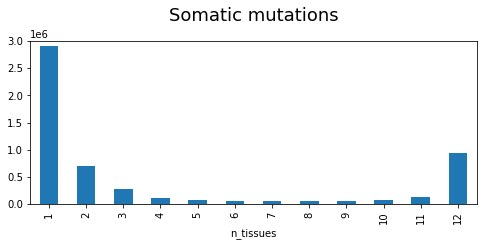

In [45]:
count_mut_tissue_df.plot.bar(figsize=(8,3),legend=False)
plt.ylim([0, 3000000])
plt.title('Somatic mutations',size=18, pad=20)

In [46]:
#save somatic muts

somatic2_df.to_csv('./output/somatic_from_hc_mutect_parents.tsv.gz',index=None,sep='\t',compression='gzip')

## 8) Filter by depth

In this step we need to import the depth per mutation position.\
We also need to establish the thresholds for the depth. We set them after evaluating the depth represented in a histogram.\
All these analyses on the depth are calculated in the ```./depth/``` folder.

In [47]:
somatic2_df = pd.read_csv('./output/somatic_from_hc_mutect_parents.tsv.gz',sep='\t')

In [48]:
samples = ['AQ5180','AQ5186','AQ5174','AX4954','AX4955','AX4956','AX4957','AX4962','AX4963','AX4964','AX4965','AX4966']
tissues = ['tumor1', 'tumor2', 'blood', 'kidney', 'liver', 'pancreas', 'heart','lung','medulla','spleen','brain','bma']
samples_dict = {samples[i]:tissues[i] for i in range(0,len(samples))}
suffixes_dict = {'tumor1':'_t1','tumor2':'_t2','blood':'_b','kidney':'_k','liver':'_l','pancreas':'_p','heart':'_h','lung':'_lu','medulla':'_me','spleen':'_s','brain':'_br','bma':'_bm'}

In [50]:
#add depth from samtools file

root_to_depth = '/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt1/all_tissues/somatic_files_with_new_tissues/depth/'
# root_to_depth = './depth/' # change at the end

somatic3_df = somatic2_df.copy()

for sample in tqdm(samples):
    file_name = root_to_depth+sample+'_depth_muts_hc_mutect_parents.tsv.gz'
#     file_name = root_to_depth+'/'+sample+'/'+'_depth_muts.tsv.gz' #change at the end
    depth_df = pd.read_csv(file_name,sep='\t',header=None)
    depth_df = depth_df.rename(columns={0:'CHROM',1:'POS',2:'DEPTH'})

    somatic3_df = pd.merge(somatic3_df,depth_df,how='left')
    tissue = samples_dict[sample]
    suffix = suffixes_dict[tissue]
    somatic3_df = somatic3_df.rename(columns={'DEPTH':'depth'+suffix})

somatic3_df

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,...,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm
0,chr1,10147,C,-,False,False,False,False,True,True,...,1621.0,852.0,785.0,807.0,877.0,712.0,753.0,958.0,603.0,690.0
1,chr1,10327,T,-,False,False,False,False,False,False,...,902.0,372.0,367.0,310.0,430.0,344.0,390.0,451.0,323.0,314.0
2,chr1,10327,T,C,False,False,False,True,False,False,...,902.0,372.0,367.0,310.0,430.0,344.0,390.0,451.0,323.0,314.0
3,chr1,10330,C,-,False,False,False,False,False,False,...,775.0,332.0,319.0,261.0,376.0,305.0,341.0,420.0,302.0,286.0
4,chr1,10331,-,AAAA,False,False,False,False,False,False,...,931.0,377.0,372.0,311.0,436.0,354.0,399.0,467.0,341.0,317.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456302,chrY,56886961,T,C,False,False,False,False,True,False,...,314.0,277.0,293.0,273.0,293.0,278.0,194.0,355.0,302.0,359.0
5456303,chrY,56887137,TTGT,-,False,False,False,False,False,False,...,302.0,269.0,239.0,254.0,264.0,277.0,162.0,351.0,252.0,289.0
5456304,chrY,56887478,T,G,True,False,False,False,False,False,...,10.0,22.0,17.0,13.0,23.0,9.0,6.0,21.0,30.0,21.0
5456305,chrY,56887487,T,G,True,False,False,False,False,False,...,7.0,15.0,13.0,9.0,17.0,7.0,5.0,18.0,25.0,14.0


In [51]:
print(len(somatic3_df),'muts')
somatic3_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(somatic3_df),'muts after drop_duplicates')

5456307 muts
5456307 muts after drop_duplicates


The following thresholds have been set after evaluating the depth histograms:

In [52]:
def filter_tumor1 (depth,chrom):
    #Tumor1
    if chrom == 'chrY':
        return False
    elif chrom == 'chr1':
        if depth > 40 and depth < 170:
            return True
        else:
            return False
    elif chrom == 'chr17':
        if depth > 80 and depth < 200:
            return True
        else:
            return False
    else:
        if depth > 80 and depth < 170:
            return True
        else:
            return False

def filter_tumor2 (depth,chrom):
    #Tumor2
    if chrom == 'chrY':
        return False
    elif chrom == 'chr22':
        if depth > 40 and depth < 170:
            return True
        else:
            return False
    else:
        if depth > 80 and depth < 170:
            return True
        else:
            return False
    
def filter_medulla (depth,chrom):
    if chrom == 'chrY':
        return False
    elif depth > 40 and depth < 100:
        return True
    else:
        return False
    

def filter_tissues (depth,chrom):
    if chrom == 'chrY':
        return False
    elif depth > 80 and depth < 170:
        return True
    else:
        return False

for tissue in tqdm(tissues):
    suffix = suffixes_dict[tissue]
    if tissue == 'tumor1':
        f = filter_tumor1
    elif tissue == 'tumor2':
        f = filter_tumor2
    elif tissue == 'medulla':
        f = filter_medulla
    else:
        f = filter_tissues
    somatic3_df['filter_depth'+suffix] = somatic3_df.progress_apply(lambda row: f(row['depth'+suffix],row['CHROM']),axis=1)

somatic3_df

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,...,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm
0,chr1,10147,C,-,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,chr1,10327,T,-,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,chr1,10327,T,C,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,chr1,10330,C,-,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,chr1,10331,-,AAAA,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456302,chrY,56886961,T,C,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5456303,chrY,56887137,TTGT,-,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5456304,chrY,56887478,T,G,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5456305,chrY,56887487,T,G,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [53]:
filter_depth_cols = ['filter_depth'+suffixes_dict[tissue] for tissue in tissues]

In [54]:

def filter_by_depth (row,filter_depth_cols):
    depth_true = []
    for col in filter_depth_cols:
        if row[col] == True:
            depth_true.append(True)
    if sum(depth_true) == len(filter_depth_cols):
        return True
    else:
        return False
somatic3_df['filter_depth_all'] = somatic3_df.progress_apply(lambda row: filter_by_depth (row,filter_depth_cols),axis=1)
filt_depth_df = somatic3_df[somatic3_df['filter_depth_all']==True]
filt_depth_df

,CHROM,POS,REF,ALT,tumor1,tumor2,blood,kidney,liver,pancreas,...,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all
19,chr1,12807,C,T,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20,chr1,13418,G,A,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
21,chr1,13912,G,A,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
28,chr1,14398,TGT,-,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
59,chr1,19172,A,G,True,True,True,False,False,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5432667,chrX,156008948,TG,-,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
5432668,chrX,156008960,TTTA,-,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
5432682,chrX,156019901,GGGTCAGGGTCAGGGTGA,-,False,False,False,True,False,False,...,True,True,True,True,True,True,True,True,True,True
5432715,chrX,156028527,C,G,False,False,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True


In [55]:
print(len(filt_depth_df),'muts')
filt_depth_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_depth_df),'muts after drop_duplicates')

2594163 muts
2594163 muts after drop_duplicates


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
#save table
filt_depth_df.to_csv('./output/somatic_depth_filtered_hc_mutect_parents.tsv.gz',index=None,sep='\t',compression='gzip')

## 9 ) Rescue mutations from parents bams

In [57]:
suffixes2_dict = {sample:suffixes_dict[samples_dict[sample]] for sample in samples}
suffixes2_dict['AW8063'] = '_m'
suffixes2_dict['AW8064'] = '_f'

samples_dict['AW8063'] = 'mother'
samples_dict['AW8064'] = 'father'

In [58]:
suffixes_dict

{'tumor1': '_t1',
 'tumor2': '_t2',
 'blood': '_b',
 'kidney': '_k',
 'liver': '_l',
 'pancreas': '_p',
 'heart': '_h',
 'lung': '_lu',
 'medulla': '_me',
 'spleen': '_s',
 'brain': '_br',
 'bma': '_bm'}

In [59]:
#save necessary json files for running the python script
import json
with(open('./dictionaries/parents_suffixes_dict.json','w')) as f:
    json.dump(suffixes2_dict,f)
with(open('./dictionaries/parents_samples_dict.json','w')) as f:
    json.dump(samples_dict,f)

Here needs to be executed the scripts to annotate the rescued mutations.\
Follow the instructions in the ```./rescued_muts/``` folder and then continue

In [61]:
#load rescued mutations
# root_to_rescued_muts = '/workspace/projects/sjd_pediatric_tumors/mafs_platinum/20220809/pt1/all_tissues/somatic_files_with_new_tissues/'
root_to_rescued_muts = './rescued_muts/' # fix at the end

rescued_snv_bam_df = pd.read_csv(root_to_rescued_muts+'rescued_snv_muts_from_bam.tsv.gz',sep='\t')

rescued_indel_bam_df = pd.read_csv(root_to_rescued_muts+'rescued_indel_muts_from_bam.tsv.gz',sep='\t')

rescued_bam_df = pd.concat([rescued_snv_bam_df,rescued_indel_bam_df],ignore_index=True)
rescued_bam_df

,CHROM,POS,REF,ALT,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,...,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father
0,chr1,12807,C,T,0.8819,15,112,127,0.8613,18,...,True,True,True,True,True,True,True,True,True,True
1,chr1,13418,G,A,0.1667,95,19,114,0.1832,107,...,True,True,True,True,True,True,True,True,True,True
2,chr1,13912,G,A,0.1628,72,14,86,0.2222,84,...,True,True,True,True,True,True,True,True,True,True
3,chr1,19172,A,G,0.5000,43,43,86,0.4355,70,...,True,True,True,True,True,True,True,True,True,True
4,chr1,28354,C,T,0.1075,83,10,93,0.1913,93,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594158,chrX,156008922,TGTGTGTGTGTTTGTGTGTGTATGTCTGTG,-,0.0000,100,0,100,0.0000,87,...,False,False,False,False,True,False,False,False,False,False
2594159,chrX,156008942,TATGTC,-,0.0000,100,0,100,0.0099,100,...,False,False,False,False,False,False,False,False,False,False
2594160,chrX,156008948,TG,-,0.0108,92,1,93,0.0000,93,...,True,True,True,True,True,True,True,False,False,False
2594161,chrX,156008960,TTTA,-,0.0000,86,0,86,0.0099,100,...,True,True,True,False,False,False,False,False,False,False


In [62]:
print(len(rescued_bam_df),'muts')
rescued_bam_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(rescued_bam_df),'muts after drop_duplicates')

2594163 muts
2594163 muts after drop_duplicates


In [63]:
filt_depth_df = pd.read_csv('./output/somatic_depth_filtered_hc_mutect_parents.tsv.gz',sep='\t')
filt_depth2_df = filt_depth_df.drop(tissues+['n_tissues'],axis=1)
filt_depth2_df

,CHROM,POS,REF,ALT,_merge,parents,mut_type,depth_t1,depth_t2,depth_b,...,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all
0,chr1,12807,C,T,NaN,False,snv,127.0,137.0,114.0,...,True,True,True,True,True,True,True,True,True,True
1,chr1,13418,G,A,NaN,False,snv,114.0,131.0,133.0,...,True,True,True,True,True,True,True,True,True,True
2,chr1,13912,G,A,NaN,False,snv,86.0,108.0,104.0,...,True,True,True,True,True,True,True,True,True,True
3,chr1,14398,TGT,-,NaN,False,indel,112.0,112.0,106.0,...,True,True,True,True,True,True,True,True,True,True
4,chr1,19172,A,G,NaN,False,snv,86.0,124.0,118.0,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594158,chrX,156008948,TG,-,NaN,False,indel,125.0,126.0,159.0,...,True,True,True,True,True,True,True,True,True,True
2594159,chrX,156008960,TTTA,-,NaN,False,indel,115.0,128.0,153.0,...,True,True,True,True,True,True,True,True,True,True
2594160,chrX,156019901,GGGTCAGGGTCAGGGTGA,-,NaN,False,indel,154.0,115.0,142.0,...,True,True,True,True,True,True,True,True,True,True
2594161,chrX,156028527,C,G,NaN,False,snv,109.0,106.0,124.0,...,True,True,True,True,True,True,True,True,True,True


In [64]:
filt_rescued_df = pd.merge(filt_depth2_df,rescued_bam_df,how='left')
filt_rescued_df

,CHROM,POS,REF,ALT,_merge,parents,mut_type,depth_t1,depth_t2,depth_b,...,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father
0,chr1,12807,C,T,NaN,False,snv,127.0,137.0,114.0,...,True,True,True,True,True,True,True,True,True,True
1,chr1,13418,G,A,NaN,False,snv,114.0,131.0,133.0,...,True,True,True,True,True,True,True,True,True,True
2,chr1,13912,G,A,NaN,False,snv,86.0,108.0,104.0,...,True,True,True,True,True,True,True,True,True,True
3,chr1,14398,TGT,-,NaN,False,indel,112.0,112.0,106.0,...,True,True,True,True,True,True,True,True,True,True
4,chr1,19172,A,G,NaN,False,snv,86.0,124.0,118.0,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594158,chrX,156008948,TG,-,NaN,False,indel,125.0,126.0,159.0,...,True,True,True,True,True,True,True,False,False,False
2594159,chrX,156008960,TTTA,-,NaN,False,indel,115.0,128.0,153.0,...,True,True,True,False,False,False,False,False,False,False
2594160,chrX,156019901,GGGTCAGGGTCAGGGTGA,-,NaN,False,indel,154.0,115.0,142.0,...,False,True,False,False,False,False,False,False,False,False
2594161,chrX,156028527,C,G,NaN,False,snv,109.0,106.0,124.0,...,True,True,True,True,True,True,True,True,True,True


In [220]:
print(len(filt_rescued_df),'muts')
filt_rescued_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_rescued_df),'muts after drop_duplicates')

2594163 muts
2594163 muts after drop_duplicates


In [65]:
filt_rescued_df.groupby(['mother','father']).count()

CHROM      POS      REF      ALT  _merge  parents  mut_type  \
mother father                                                                  
False  False   1122915  1122915  1122915  1122915       0  1122915   1122915   
       True     310366   310366   310366   310366       0   310366    310366   
True   False    319797   319797   319797   319797       0   319797    319797   
       True     841085   841085   841085   841085       0   841085    841085   

               depth_t1  depth_t2  depth_b  ...    blood   kidney    liver  \
mother father                               ...                              
False  False    1122915   1122915  1122915  ...  1122915  1122915  1122915   
       True      310366    310366   310366  ...   310366   310366   310366   
True   False     319797    319797   319797  ...   319797   319797   319797   
       True      841085    841085   841085  ...   841085   841085   841085   

               pancreas    heart     lung  medulla   spleen    brain      bma  
mother father                                                                  
False  False    1122915  1122915  1122915  1122915  1122915  1122915  1122915  
       True      310366   310366   310366   310366   310366   310366   310366  
True   False     319797   319797   319797   319797   319797   319797   319797  
       True      841085   841085   841085   841085   841085   841085   841085  

[4 rows x 100 columns]

In [66]:
# re-count the number of tissues in which a variant is present
def count_tissues (row,tissues):
    all_tissues = []
    for tissue in tissues:
        all_tissues.append(row[tissue])
    return sum(all_tissues)

filt_rescued_df['n_tissues'] = filt_rescued_df.progress_apply(lambda row: count_tissues(row, tissues),axis=1)

## 10)  Remove all variants present in parents' bams

In [67]:
filt_rescued_df['parents'] = filt_rescued_df.apply(lambda row: True if (row['father']==True or row['mother']==True) else False,axis=1)
filt_rescued_df.groupby('parents').count()

,CHROM,POS,REF,ALT,_merge,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues
parents,,,,,,,,,,,,,,,,,,,,,
False,1122915,1122915,1122915,1122915,0,1122915,1122915,1122915,1122915,1122915,...,1122915,1122915,1122915,1122915,1122915,1122915,1122915,1122915,1122915,1122915
True,1471248,1471248,1471248,1471248,0,1471248,1471248,1471248,1471248,1471248,...,1471248,1471248,1471248,1471248,1471248,1471248,1471248,1471248,1471248,1471248


In [68]:
print(len(filt_rescued_df),'muts')
filt_rescued_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_rescued_df),'muts after drop_duplicates')

2594163 muts
2594163 muts after drop_duplicates


In [69]:
count_mut_tissue_df = filt_rescued_df[['n_tissues','ALT']][filt_rescued_df ['parents']==True].groupby('n_tissues').count()
count_mut_tissue_df

,ALT
n_tissues,
0,4404
1,3607
2,3580
3,4522
4,6824
5,12045
6,21350
7,37183
8,55915


In [70]:
#filter out all variants present in parents
filt_parents_df = filt_rescued_df[filt_rescued_df['parents']==False]

In [71]:
print(len(filt_parents_df),'muts')
filt_parents_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_parents_df),'muts after drop_duplicates')

1122915 muts
1122915 muts after drop_duplicates


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [76]:
filt_parents_df.groupby('n_tissues').count()

,CHROM,POS,REF,ALT,_merge,parents,mut_type,depth_t1,depth_t2,depth_b,...,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father
n_tissues,,,,,,,,,,,,,,,,,,,,,
0,467421,467421,467421,467421,0,467421,467421,467421,467421,467421,...,467421,467421,467421,467421,467421,467421,467421,467421,467421,467421
1,108530,108530,108530,108530,0,108530,108530,108530,108530,108530,...,108530,108530,108530,108530,108530,108530,108530,108530,108530,108530
2,45484,45484,45484,45484,0,45484,45484,45484,45484,45484,...,45484,45484,45484,45484,45484,45484,45484,45484,45484,45484
3,33283,33283,33283,33283,0,33283,33283,33283,33283,33283,...,33283,33283,33283,33283,33283,33283,33283,33283,33283,33283
4,31504,31504,31504,31504,0,31504,31504,31504,31504,31504,...,31504,31504,31504,31504,31504,31504,31504,31504,31504,31504
5,35144,35144,35144,35144,0,35144,35144,35144,35144,35144,...,35144,35144,35144,35144,35144,35144,35144,35144,35144,35144
6,45659,45659,45659,45659,0,45659,45659,45659,45659,45659,...,45659,45659,45659,45659,45659,45659,45659,45659,45659,45659
7,59626,59626,59626,59626,0,59626,59626,59626,59626,59626,...,59626,59626,59626,59626,59626,59626,59626,59626,59626,59626
8,70852,70852,70852,70852,0,70852,70852,70852,70852,70852,...,70852,70852,70852,70852,70852,70852,70852,70852,70852,70852


In [72]:
filt_parents_df.to_csv('./output/somatic_rescued_filtered.tsv.gz',sep='\t',compression='gzip',index=None)

## 11) Remove variants with no reads in any tissue after bam curation

In [73]:
#filter mutations that are not present anymore in any tissue (n_tissues==0)
filt_no_zeros_df = filt_parents_df[filt_parents_df['n_tissues']!=0]

In [74]:
print(len(filt_no_zeros_df),'muts')
filt_no_zeros_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_no_zeros_df),'muts after drop_duplicates')

655494 muts
655494 muts after drop_duplicates


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
#save table, to analyse for sequencing artifacts
filt_no_zeros_df.to_csv('./output/somatic_filtered_no_zeros_hc_mutect.tsv.gz',sep='\t',index=None, compression='gzip')

## 12) Run VEP

In [77]:
filt_no_zeros_df = pd.read_csv('./output/somatic_filtered_no_zeros_hc_mutect.tsv.gz',sep='\t')

Prepare file to run vep

In [78]:
def define_end (row):
    if row['mut_type'] == 'indel':
        pos = row['POS']
        if row['REF'] == '-':
            return pos -1
        else:
            nt = len(row['REF'])
            return pos + nt -1
    elif row['mut_type'] == 'mnv':
        pos = row['POS']
        nt = len(row['REF'])
        return pos + nt -1
    else:
        return row['POS']
    
#change format for vep input

filt_no_zeros_df['chromosome'] = filt_no_zeros_df['CHROM'].str.split('chr',expand=True)[1]
filt_no_zeros_df['start'] = filt_no_zeros_df['POS']
filt_no_zeros_df['end'] = filt_no_zeros_df.progress_apply(lambda row: define_end(row),axis=1)
filt_no_zeros_df['allele'] = filt_no_zeros_df['REF'] + '/' + filt_no_zeros_df['ALT']
filt_no_zeros_df['strand'] = '+'
vep_cols = ['chromosome','start','end','allele','strand']
filt_no_zeros_df[vep_cols]

,chromosome,start,end,allele,strand
0,1,28367,28367,G/A,+
1,1,775209,775208,-/A,+
2,1,783717,783717,A/C,+
3,1,789529,789529,A/C,+
4,1,789536,789536,T/A,+
...,...,...,...,...,...
655489,X,156008922,156008951,TGTGTGTGTGTTTGTGTGTGTATGTCTGTG/-,+
655490,X,156008942,156008947,TATGTC/-,+
655491,X,156008948,156008949,TG/-,+
655492,X,156008960,156008963,TTTA/-,+


In [79]:
#save table to run vep on variants
chroms = list(range(1,23))
chroms = [str(chrom) for chrom in chroms]
chroms.append('X')
chroms.append('Y')

for chrom in tqdm(chroms):
    chr_df = filt_no_zeros_df[vep_cols][filt_no_zeros_df['chromosome']==chrom]
    chr_df.to_csv('./vep/vep_input/chr'+chrom+'_somatic_muts.tsv.gz',sep='\t',index=None,header=None,compression='gzip')

At this point, run vep following the indications at ```./vep/``` folder

#### Load vep output

In [80]:
vep_df = pd.DataFrame()
for chrom in tqdm(chroms):
    if chrom == 'Y':
        pass
    else:
        df1 = pd.read_csv('./vep/vep_process/chr'+chrom+'_somatic_muts_vep_filt.tsv.gz',sep='\t')
        vep_df = pd.concat([vep_df,df1],ignore_index=True)
vep_df = vep_df.rename(columns={'#CHROM':'CHROM'})
vep_df['CHROM'] = vep_df['CHROM'].astype(str)
vep_df['CHROM'] = 'chr' + vep_df['CHROM']
vep_df

,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,...,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,CHROM,POS,Change,REF,ALT
0,1_100000875_-/T,1:100000874-100000875,T,ENSG00000117620,ENST00000370153,Transcript,intron_variant,-,-,-,...,-,-,rs139324139,0.064713,-,chr1,100000875,-/T,-,T
1,1_100001445_-/T,1:100001444-100001445,T,ENSG00000117620,ENST00000370153,Transcript,intron_variant,-,-,-,...,-,-,rs986260488,0.000606,-,chr1,100001445,-/T,-,T
2,1_100002783_-/T,1:100002782-100002783,T,ENSG00000117620,ENST00000370153,Transcript,intron_variant,-,-,-,...,-,-,rs35227168,0.231650,-,chr1,100002783,-/T,-,T
3,1_100002783_T/-,1:100002783,-,ENSG00000117620,ENST00000370153,Transcript,intron_variant,-,-,-,...,-,-,rs1257924786,0.000769,-,chr1,100002783,T/-,T,-
4,1_100003409_T/A,1:100003409,A,ENSG00000117620,ENST00000370153,Transcript,intron_variant,-,-,-,...,-,-,chr1:100003409-100003409,0.000000,-,chr1,100003409,T/A,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651280,X_99968573_-/T,X:99968572-99968573,T,-,-,-,intergenic_variant,-,-,-,...,-,-,-,0.000000,-,chrX,99968573,-/T,-,T
651281,X_99969677_G/C,X:99969677,C,-,-,-,intergenic_variant,-,-,-,...,-,-,rs867886719,0.007374,-,chrX,99969677,G/C,G,C
651282,X_99975248_TC/-,X:99975248-99975249,-,-,-,-,intergenic_variant,-,-,-,...,-,-,chrX:99975248-99975250,0.000000,-,chrX,99975248,TC/-,TC,-
651283,X_99983413_-/GT,X:99983412-99983413,GT,-,-,-,intergenic_variant,-,-,-,...,-,-,chrX:99983413-99983413,0.004099,-,chrX,99983413,-/GT,-,GT


In [81]:
filt_no_zeros_df.drop('_merge',axis=1,inplace=True)
filt_vep_df = pd.merge(filt_no_zeros_df,vep_df,how='outer',on=['CHROM','POS','REF','ALT'],indicator=True)
filt_vep_df

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,_merge
0,chr1,28367,G,A,False,snv,87.0,101.0,106.0,124.0,...,-,-,-,-,-,rs1450278619,0.000000,-,G/A,both
1,chr1,775209,-,A,False,indel,70.0,127.0,140.0,136.0,...,-,-,-,-,-,chr1:775209-775209,0.051630,-,-/A,both
2,chr1,783717,A,C,False,snv,79.0,157.0,161.0,119.0,...,-,-,-,-,-,rs4498745,0.000221,-,A/C,both
3,chr1,789529,A,C,False,snv,62.0,111.0,128.0,111.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,789536,T,A,False,snv,67.0,118.0,137.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655489,chrX,156008922,TGTGTGTGTGTTTGTGTGTGTATGTCTGTG,-,False,indel,125.0,125.0,156.0,164.0,...,-,-,-,-,-,-,0.000000,-,TGTGTGTGTGTTTGTGTGTGTATGTCTGTG/-,both
655490,chrX,156008942,TATGTC,-,False,indel,123.0,126.0,160.0,154.0,...,-,-,-,-,-,chrX:156008942-156008948,0.000031,-,TATGTC/-,both
655491,chrX,156008948,TG,-,False,indel,125.0,126.0,159.0,152.0,...,-,-,-,-,-,rs1345676530,0.007648,-,TG/-,both
655492,chrX,156008960,TTTA,-,False,indel,115.0,128.0,153.0,158.0,...,-,-,-,-,-,chrX:156008960-156008964,0.000014,-,TTTA/-,both


In [82]:
# some vep variants could not be merged
filt_vep_df.groupby(['_merge']).count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change
_merge,,,,,,,,,,,,,,,,,,,,,
left_only,4209,4209,4209,4209,4209,4209,4209,4209,4209,4209,...,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
both,651285,651285,651285,651285,651285,651285,651285,651285,651285,651285,...,651285,651285,651285,651285,651285,651285,651285,651285,651285,651285


In [83]:
# all vep variants could be merged!
filt_vep_df.groupby(['_merge','mut_type']).count()

CHROM       POS       REF       ALT   parents  \
_merge     mut_type                                                     
left_only  indel       3117.0    3117.0    3117.0    3117.0    3117.0   
           snv         1092.0    1092.0    1092.0    1092.0    1092.0   
right_only indel          NaN       NaN       NaN       NaN       NaN   
           snv            NaN       NaN       NaN       NaN       NaN   
both       indel     490352.0  490352.0  490352.0  490352.0  490352.0   
           snv       160933.0  160933.0  160933.0  160933.0  160933.0   

                     depth_t1  depth_t2   depth_b   depth_k   depth_l  ...  \
_merge     mut_type                                                    ...   
left_only  indel       3117.0    3117.0    3117.0    3117.0    3117.0  ...   
           snv         1092.0    1092.0    1092.0    1092.0    1092.0  ...   
right_only indel          NaN       NaN       NaN       NaN       NaN  ...   
           snv            NaN       NaN       NaN       NaN       NaN  ...   
both       indel     490352.0  490352.0  490352.0  490352.0  490352.0  ...   
           snv       160933.0  160933.0  160933.0  160933.0  160933.0  ...   

                       EAS_AF    EUR_AF    SAS_AF  CLIN_SIG   SOMATIC  \
_merge     mut_type                                                     
left_only  indel          0.0       0.0       0.0       0.0       0.0   
           snv            0.0       0.0       0.0       0.0       0.0   
right_only indel          NaN       NaN       NaN       NaN       NaN   
           snv            NaN       NaN       NaN       NaN       NaN   
both       indel     490352.0  490352.0  490352.0  490352.0  490352.0   
           snv       160933.0  160933.0  160933.0  160933.0  160933.0   

                        PHENO   gnomADg  gnomADg_AF  gnomADg_NFE    Change  
_merge     mut_type                                                         
left_only  indel          0.0       0.0         0.0          0.0       0.0  
           snv            0.0       0.0         0.0          0.0       0.0  
right_only indel          NaN       NaN         NaN          NaN       NaN  
           snv            NaN       NaN         NaN          NaN       NaN  
both       indel     490352.0  490352.0    490352.0     490352.0  490352.0  
           snv       160933.0  160933.0    160933.0     160933.0  160933.0  

[6 rows x 141 columns]

In [84]:
print(len(filt_vep_df), 'total number of mutations')
filt_vep_df = filt_vep_df[filt_vep_df['_merge']=='both']
filt_vep_df.drop('_merge',axis=1,inplace=True)
print(len(filt_vep_df), 'mutations with vep info')

655494 total number of mutations
651285 mutations with vep info


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [85]:
print(len(filt_vep_df),'muts')
filt_vep_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_vep_df),'muts after drop_duplicates')

651285 muts
651285 muts after drop_duplicates


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [86]:
count_mut_tissue_df = filt_vep_df[['n_tissues','ALT','mut_type']].groupby('n_tissues').count()
count_mut_tissue_df = count_mut_tissue_df[['ALT']]
count_mut_tissue_df

,ALT
n_tissues,
1,107826
2,45151
3,33082
4,31285
5,34909
6,45358
7,59284
8,70395
9,73521


In [87]:
filt_vep_df.to_csv('./output/somatic_filtered_vep_hc_mutect.tsv.gz',sep='\t',index=None, compression='gzip')

## 13) Remove sequencing artifacts

First, this notebook has to be run: `calculate_sequencing_artifacts_with_betabinomial.ipynb`\
In that notebook, we annotate the mutations that are present in a cohort of pediatric blood samples.

In [88]:
#load blood dict
blood_suffixes_dict = json.load(open('./dictionaries/blood_suffixes_dict.json','rb'))
blood_samples_dict = json.load(open('./dictionaries/blood_samples_dict.json','rb'))
blood_bams_dict = json.load(open('./dictionaries/blood_bams_dict.json','rb'))
blood_cols = [blood_samples_dict[sample] for sample in blood_samples_dict.keys() if sample != 'AQ5174']

In [89]:
#load betabinomial processed table
filt_artifacts_df = pd.read_csv('./output/somatic_filtered_artifacts.tsv.gz',sep='\t')

In [90]:
list(filt_artifacts_df)

['CHROM',
 'POS',
 'REF',
 'ALT',
 'parents',
 'mut_type',
 'depth_t1',
 'depth_t2',
 'depth_b',
 'depth_k',
 'depth_l',
 'depth_p',
 'depth_h',
 'depth_lu',
 'depth_me',
 'depth_s',
 'depth_br',
 'depth_bm',
 'filter_depth_t1',
 'filter_depth_t2',
 'filter_depth_b',
 'filter_depth_k',
 'filter_depth_l',
 'filter_depth_p',
 'filter_depth_h',
 'filter_depth_lu',
 'filter_depth_me',
 'filter_depth_s',
 'filter_depth_br',
 'filter_depth_bm',
 'filter_depth_all',
 'AF_t1',
 'ref_reads_t1',
 'alt_reads_t1',
 'DP_t1',
 'AF_t2',
 'ref_reads_t2',
 'alt_reads_t2',
 'DP_t2',
 'AF_b',
 'ref_reads_b',
 'alt_reads_b',
 'DP_b',
 'AF_k',
 'ref_reads_k',
 'alt_reads_k',
 'DP_k',
 'AF_l',
 'ref_reads_l',
 'alt_reads_l',
 'DP_l',
 'AF_p',
 'ref_reads_p',
 'alt_reads_p',
 'DP_p',
 'AF_h',
 'ref_reads_h',
 'alt_reads_h',
 'DP_h',
 'AF_lu',
 'ref_reads_lu',
 'alt_reads_lu',
 'DP_lu',
 'AF_me',
 'ref_reads_me',
 'alt_reads_me',
 'DP_me',
 'AF_s',
 'ref_reads_s',
 'alt_reads_s',
 'DP_s',
 'AF_br',
 'ref_read

In [91]:
print(len(filt_artifacts_df),'muts')
filt_artifacts_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_artifacts_df),'muts after drop_duplicates')

2438 muts
2438 muts after drop_duplicates


In [92]:
count_mut_tissue_df = filt_artifacts_df[['n_tissues','ALT','mut_type']].groupby('n_tissues').count()
count_mut_tissue_df = count_mut_tissue_df[['ALT']]
count_mut_tissue_df

,ALT
n_tissues,
1,621
2,433
3,539
4,441
5,166
6,57
7,14
8,1
9,5


## 14) Flag de-novo germline

Make a binomial test for each variant, to test whether they are at 0.5 VAF or higher (so, that they are clonal)  
Adjust with FDR   
After doing that for each tissue, germline variants will be assumed to be those that are clonal in all tissues (those that have the adj-pvalue>0.00001 non-significant)  
Taken from *Coorens et al Lineage-independent tumors in bilateral neuroblastoma, NEJM 2020*

In [93]:
filt_artifacts_df = pd.read_csv('./output/somatic_filtered_artifacts.tsv.gz',sep='\t')

In [94]:
def denovo_germline (df1):

    def binomial_test(row,p,alternative,suffixes_dict):
        for tissue in suffixes_dict.keys():
            suffix = suffixes_dict[tissue]
            alt_reads = row['alt_reads'+suffix]
            depth = row['DP'+suffix]
            row['pval'+suffix] = stats.binom_test(alt_reads,depth, p, alternative)        
        return row

    df1 = df1.progress_apply(lambda row: binomial_test(row,0.5,'less',suffixes_dict),axis=1)

    #adjusted pval

    def fdr(p_val,total,ranked_p_values,suffix,i):
        fdr = p_val * total / ranked_p_values[i]
        if fdr > 1:
            fdr = 1
        i =  i +1
        return fdr

    for tissue in suffixes_dict.keys():
        suffix = suffixes_dict[tissue]
        p_vals = df1['pval'+suffix]
        ranked_p_values = stats.rankdata(p_vals)
        total = len(p_vals)
        i = 0
        df1['qval'+suffix] = df1['pval'+suffix].progress_apply(lambda p_val: fdr(p_val,total,ranked_p_values,suffix,i))

    # flag variants that are clonal in all normal tissues ~ denovo germline
    qval_cols = ['qval'+suffixes_dict[tissue] for tissue in suffixes_dict.keys()]

    suffixes2_dict = {sample:suffix for sample,suffix in suffixes_dict.items()}

    def denovo_germline (row,threshold,suffixes_dict):
        qvals = []
        for tissue in suffixes_dict.keys():
            suffix = suffixes_dict[tissue]
            if row['qval'+suffix] > threshold:
                qvals.append(True)
        if len(qvals) == len(suffixes_dict):
            return True
        else:
            return False

    df1['denovo_germline'] = df1.progress_apply(lambda row: denovo_germline(row,0.00001,suffixes2_dict),axis=1)

    af_cols = ['AF'+suffixes_dict[tissue] for tissue in suffixes_dict.keys()]

    return df1

In [95]:
filt_denovo_df = denovo_germline(filt_artifacts_df)
filt_denovo_df

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
0,chr1,865445,G,C,False,snv,81.0,136.0,128.0,152.0,...,1.140146e-38,4.983417e-42,3.221510e-40,1.411108e-42,2.816809e-40,6.019900e-24,2.205815e-47,5.422803e-44,1.896295e-46,False
1,chr1,4101122,G,T,False,snv,81.0,117.0,134.0,124.0,...,1.080279e-33,6.229271e-43,8.247065e-38,2.266049e-30,2.682705e-37,9.863003e-20,2.205815e-47,4.548977e-37,2.485512e-41,False
2,chr1,4352976,G,A,False,snv,73.0,121.0,126.0,143.0,...,3.827991e-41,1.240120e-47,1.649413e-37,9.517816e-38,3.304770e-35,1.232875e-20,4.517508e-44,1.037111e-42,2.545165e-38,False
3,chr1,7591505,T,C,False,snv,75.0,121.0,129.0,122.0,...,6.857147e-35,8.360786e-35,1.288604e-39,4.082971e-32,3.151674e-41,5.171054e-14,1.515824e-36,2.776475e-41,1.213629e-44,False
4,chr1,7983849,G,T,False,snv,76.0,125.0,127.0,130.0,...,2.852789e-37,7.026617e-40,3.298826e-37,4.223600e-31,2.165814e-30,1.926368e-22,3.446585e-49,9.316304e-34,5.212497e-35,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,chr6,165412639,T,G,False,snv,113.0,126.0,132.0,139.0,...,4.253323e-42,2.612746e-36,1.623022e-34,4.867281e-39,1.290926e-37,2.351523e-26,3.641464e-21,1.863261e-33,9.942049e-41,False
2434,chr7,57050159,C,G,False,snv,115.0,133.0,155.0,108.0,...,5.086819e-26,3.826070e-26,2.337539e-27,1.436593e-27,9.028329e-28,7.349397e-12,3.215020e-39,5.309906e-27,3.716271e-36,False
2435,chr7,57107156,G,A,False,snv,127.0,127.0,162.0,159.0,...,8.607259e-38,1.869165e-26,7.896844e-25,1.642169e-22,1.174473e-28,4.957144e-09,1.700112e-28,1.904664e-21,6.376770e-33,False
2436,chr7,65173952,GGGTAACAGACCT,-,False,indel,120.0,103.0,121.0,131.0,...,2.436825e-28,9.333663e-18,1.562210e-16,4.621489e-16,2.144070e-20,1.258474e-14,7.546196e-26,7.171056e-14,2.596092e-35,False


In [96]:
af_cols = ['AF'+suffixes_dict[sample] for sample in suffixes_dict.keys()]
qval_cols = ['qval'+suffixes_dict[sample] for sample in suffixes_dict.keys()]

In [97]:
filt_denovo_df[af_cols+qval_cols+['denovo_germline']][filt_denovo_df['denovo_germline']==True] 

,AF_t1,AF_t2,AF_b,AF_k,AF_l,AF_p,AF_h,AF_lu,AF_me,AF_s,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
24,0.8261,0.4818,0.4403,0.3986,0.5435,0.5526,0.4560,0.4783,0.5065,0.4362,...,0.027998,1.000000,1.000000,1.0,1.0,1.0,0.564389,1.000000,1.000000,True
45,0.8767,0.5652,0.4365,0.4922,0.5154,0.3778,0.5537,0.4841,0.4571,0.3562,...,1.000000,1.000000,0.019935,1.0,1.0,1.0,0.002578,1.000000,1.000000,True
59,0.8367,0.5591,0.5221,0.5354,0.4426,0.5448,0.5625,0.5000,0.6714,0.5411,...,1.000000,0.830340,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,True
140,0.5603,0.5000,0.4859,0.4583,0.4783,0.4846,0.4646,0.4435,0.5246,0.4961,...,0.609757,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,True
173,0.5379,0.4685,0.4296,0.4113,0.5935,0.5152,0.4188,0.5267,0.4933,0.4966,...,0.063550,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2247,0.6404,0.6139,0.6087,0.5726,0.4790,0.5455,0.5766,0.5862,0.5455,0.4896,...,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,True
2283,0.4174,0.4308,0.5909,0.5573,0.4365,0.6304,0.4433,0.5397,0.4800,0.5646,...,1.000000,0.629379,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,True
2306,0.4771,0.5909,0.3952,0.5344,0.5500,0.5484,0.5000,0.5224,0.5692,0.5305,...,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.605665,0.275140,True
2346,0.4194,0.5570,0.5607,0.4891,0.4538,0.5221,0.4095,0.5043,0.5556,0.4476,...,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.973605,1.000000,0.834575,True


In [98]:
filt_denovo2_df = filt_denovo_df[filt_denovo_df['denovo_germline']==False]
filt_denovo2_df

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
0,chr1,865445,G,C,False,snv,81.0,136.0,128.0,152.0,...,1.140146e-38,4.983417e-42,3.221510e-40,1.411108e-42,2.816809e-40,6.019900e-24,2.205815e-47,5.422803e-44,1.896295e-46,False
1,chr1,4101122,G,T,False,snv,81.0,117.0,134.0,124.0,...,1.080279e-33,6.229271e-43,8.247065e-38,2.266049e-30,2.682705e-37,9.863003e-20,2.205815e-47,4.548977e-37,2.485512e-41,False
2,chr1,4352976,G,A,False,snv,73.0,121.0,126.0,143.0,...,3.827991e-41,1.240120e-47,1.649413e-37,9.517816e-38,3.304770e-35,1.232875e-20,4.517508e-44,1.037111e-42,2.545165e-38,False
3,chr1,7591505,T,C,False,snv,75.0,121.0,129.0,122.0,...,6.857147e-35,8.360786e-35,1.288604e-39,4.082971e-32,3.151674e-41,5.171054e-14,1.515824e-36,2.776475e-41,1.213629e-44,False
4,chr1,7983849,G,T,False,snv,76.0,125.0,127.0,130.0,...,2.852789e-37,7.026617e-40,3.298826e-37,4.223600e-31,2.165814e-30,1.926368e-22,3.446585e-49,9.316304e-34,5.212497e-35,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,chr6,165412639,T,G,False,snv,113.0,126.0,132.0,139.0,...,4.253323e-42,2.612746e-36,1.623022e-34,4.867281e-39,1.290926e-37,2.351523e-26,3.641464e-21,1.863261e-33,9.942049e-41,False
2434,chr7,57050159,C,G,False,snv,115.0,133.0,155.0,108.0,...,5.086819e-26,3.826070e-26,2.337539e-27,1.436593e-27,9.028329e-28,7.349397e-12,3.215020e-39,5.309906e-27,3.716271e-36,False
2435,chr7,57107156,G,A,False,snv,127.0,127.0,162.0,159.0,...,8.607259e-38,1.869165e-26,7.896844e-25,1.642169e-22,1.174473e-28,4.957144e-09,1.700112e-28,1.904664e-21,6.376770e-33,False
2436,chr7,65173952,GGGTAACAGACCT,-,False,indel,120.0,103.0,121.0,131.0,...,2.436825e-28,9.333663e-18,1.562210e-16,4.621489e-16,2.144070e-20,1.258474e-14,7.546196e-26,7.171056e-14,2.596092e-35,False


In [99]:
print(len(filt_denovo2_df),'muts')
filt_denovo2_df.drop_duplicates(subset=['CHROM','POS','REF','ALT'],inplace=True)
print(len(filt_denovo2_df),'muts after drop_duplicates')

2359 muts
2359 muts after drop_duplicates


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
count_mut_tissue_df = filt_denovo2_df[['n_tissues','ALT','mut_type']].groupby('n_tissues').count()
count_mut_tissue_df = count_mut_tissue_df[['ALT']]
count_mut_tissue_df

,ALT
n_tissues,
1,621
2,433
3,539
4,441
5,166
6,57
7,14
8,1
9,5


In [101]:
filt_denovo2_df.to_csv('./output/somatic_filtered_denovo_hc_mutect.tsv.gz',sep='\t',index=None,compression='gzip')

In [102]:
# save muts list containing the de novo germline as final muts list
filt_denovo_df.to_csv('./output/final_list_muts.tsv.gz',sep='\t',index=None,compression='gzip')

## 16) Count mutations

In [103]:
count_mut_tissue_df = somatic3_df[['n_tissues','ALT']].groupby('n_tissues',as_index=False).count()
count_mut_tissue_df = count_mut_tissue_df.rename(columns={'ALT':'somatic unfiltered'})
count_mut_tissue_df2 = filt_depth_df[['n_tissues','ALT']].groupby('n_tissues',as_index=False).count()
count_mut_tissue_df2 = count_mut_tissue_df2.rename(columns={'ALT':'somatic without low mappability'})
count_mut_tissue_df = pd.merge(count_mut_tissue_df,count_mut_tissue_df2,on='n_tissues',how='outer')
count_mut_tissue_df2 = filt_rescued_df[['n_tissues','ALT']].groupby('n_tissues',as_index=False).count()
count_mut_tissue_df2 = count_mut_tissue_df2.rename(columns={'ALT':'somatic with rescued from bams'})
count_mut_tissue_df = pd.merge(count_mut_tissue_df,count_mut_tissue_df2,on='n_tissues',how='outer')
count_mut_tissue_df2 = filt_parents_df[['n_tissues','ALT']].groupby('n_tissues',as_index=False).count()
count_mut_tissue_df2 = count_mut_tissue_df2.rename(columns={'ALT':'somatic without muts in parents bams'})
count_mut_tissue_df = pd.merge(count_mut_tissue_df,count_mut_tissue_df2,on='n_tissues',how='outer')
count_mut_tissue_df = count_mut_tissue_df.fillna(0)
count_mut_tissue_df2 = filt_no_zeros_df[['n_tissues','ALT']].groupby('n_tissues',as_index=False).count()
count_mut_tissue_df2 = count_mut_tissue_df2.rename(columns={'ALT':'somatic without mutations not found in any bam'})
count_mut_tissue_df = pd.merge(count_mut_tissue_df,count_mut_tissue_df2,on='n_tissues',how='outer')
count_mut_tissue_df = count_mut_tissue_df.fillna(0)
count_mut_tissue_df2 = filt_artifacts_df[['n_tissues','ALT']].groupby('n_tissues',as_index=False).count()
count_mut_tissue_df2 = count_mut_tissue_df2.rename(columns={'ALT':'somatic without artifacts'})
count_mut_tissue_df = pd.merge(count_mut_tissue_df,count_mut_tissue_df2,on='n_tissues',how='outer')
count_mut_tissue_df = count_mut_tissue_df.fillna(0)
count_mut_tissue_df2 = filt_denovo_df[['n_tissues','ALT']].groupby('n_tissues',as_index=False).count()
count_mut_tissue_df2 = count_mut_tissue_df2.rename(columns={'ALT':'somatic without de novo germline'})
count_mut_tissue_df = pd.merge(count_mut_tissue_df,count_mut_tissue_df2,on='n_tissues',how='outer')
count_mut_tissue_df = count_mut_tissue_df.fillna(0)
count_mut_tissue_df = count_mut_tissue_df.sort_values('n_tissues',ascending=True)
count_mut_tissue_df.index = count_mut_tissue_df['n_tissues']
count_mut_tissue_df.drop('n_tissues',axis=1,inplace=True)
count_mut_tissue_df

,somatic unfiltered,somatic without low mappability,somatic with rescued from bams,somatic without muts in parents bams,somatic without mutations not found in any bam,somatic without artifacts,somatic without de novo germline
n_tissues,,,,,,,
0,0.0,0.0,471825,467421,0.0,0.0,0.0
1,2916984.0,1636167.0,112137,108530,108530.0,621.0,621.0
2,706806.0,370023.0,49064,45484,45484.0,433.0,433.0
3,271961.0,109020.0,37805,33283,33283.0,539.0,539.0
4,106163.0,21472.0,38328,31504,31504.0,441.0,441.0
5,78457.0,13892.0,47189,35144,35144.0,166.0,166.0
6,63298.0,9606.0,67009,45659,45659.0,57.0,57.0
7,55504.0,7980.0,96809,59626,59626.0,14.0,14.0
8,52050.0,7087.0,126767,70852,70852.0,1.0,1.0


[Text(0, 0, '0'),
 Text(0, 0, '500000'),
 Text(0, 0, '1000000'),
 Text(0, 0, '1500000'),
 Text(0, 0, '2000000'),
 Text(0, 0, '2500000'),
 Text(0, 0, '3000000')]

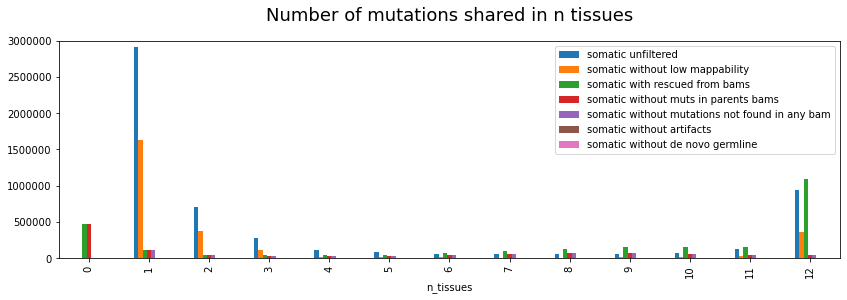

In [105]:
count_mut_tissue_df.plot.bar(figsize=(14,4))
plt.ylim([0, 3000000])
plt.title('Number of mutations shared in n tissues',size=18, pad=20)
plt.legend(bbox_to_anchor=(1, 1))
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


[Text(0, 0, '0'),
 Text(0, 0, '25000'),
 Text(0, 0, '50000'),
 Text(0, 0, '75000'),
 Text(0, 0, '100000'),
 Text(0, 0, '125000'),
 Text(0, 0, '150000'),
 Text(0, 0, '175000'),
 Text(0, 0, '200000')]

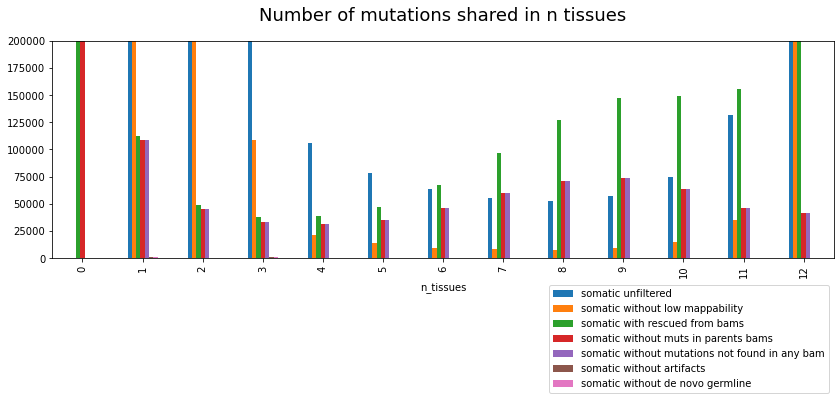

In [106]:
count_mut_tissue_df.plot.bar(figsize=(14,4))
plt.ylim([0, 200000])
plt.title('Number of mutations shared in n tissues',size=18, pad=20)
plt.legend(bbox_to_anchor=(1, -0.1))
# plt.yscale('log')
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


[Text(0, 0, '0'),
 Text(0, 0, '200'),
 Text(0, 0, '400'),
 Text(0, 0, '600'),
 Text(0, 0, '800'),
 Text(0, 0, '1000')]

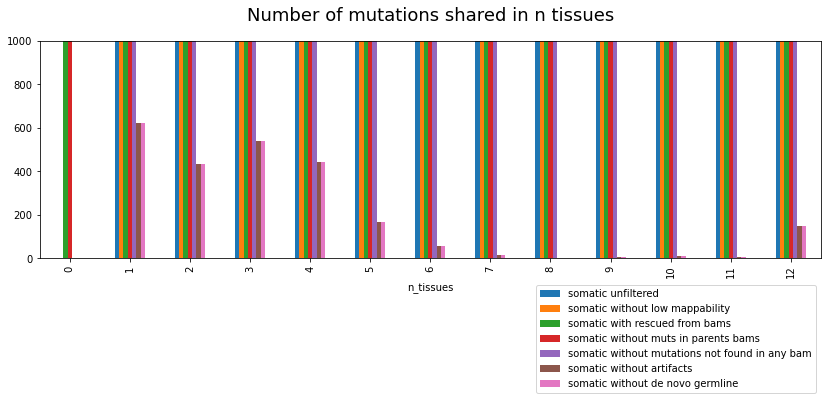

In [107]:
count_mut_tissue_df.plot.bar(figsize=(14,4))
plt.ylim([0, 1000])
plt.title('Number of mutations shared in n tissues',size=18, pad=20)
plt.legend(bbox_to_anchor=(1, -0.1))
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


## 17) Plot clustermap

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
df = filt_denovo_df

In [110]:
suffixes = [ suffixes_dict[tissue] for tissue in tissues]

af_cols = ['AF'+suffix for suffix in suffixes]
grp_df = df[['n_tissues','CHROM']].groupby('n_tissues').count()
grp_df = grp_df.rename(columns={'CHROM':'n_variants'})
grp_df

,n_variants
n_tissues,
1,621
2,433
3,539
4,441
5,166
6,57
7,14
8,1
9,5


In [111]:
print(len(df[df['AF_t1']!=0]),'muts tumor1')
print(len(df[df['AF_t2']!=0]),'muts tumor2')

1079 muts tumor1
1602 muts tumor2


In [112]:
suffixes = [ suffixes_dict[tissue] for tissue in tissues]

In [113]:
af_cols = ['AF'+suffix for suffix in suffixes]

In [114]:
suffixes3_dict = {suffix[1]:suffix[0] for suffix in suffixes_dict.items()}
suffixes3_dict

{'_t1': 'tumor1',
 '_t2': 'tumor2',
 '_b': 'blood',
 '_k': 'kidney',
 '_l': 'liver',
 '_p': 'pancreas',
 '_h': 'heart',
 '_lu': 'lung',
 '_me': 'medulla',
 '_s': 'spleen',
 '_br': 'brain',
 '_bm': 'bma'}

In [115]:
label_cols_dict = {col:suffixes3_dict[col.split('AF')[1]] for col in af_cols}
label_cols_dict['AF_t1'] = 'NB'
label_cols_dict['AF_t2'] = 'RT'
label_cols_dict

{'AF_t1': 'NB',
 'AF_t2': 'RT',
 'AF_b': 'blood',
 'AF_k': 'kidney',
 'AF_l': 'liver',
 'AF_p': 'pancreas',
 'AF_h': 'heart',
 'AF_lu': 'lung',
 'AF_me': 'medulla',
 'AF_s': 'spleen',
 'AF_br': 'brain',
 'AF_bm': 'bma'}

In [116]:
label_cols = [label_cols_dict[af] for af in label_cols_dict.keys()]
label_cols

['NB',
 'RT',
 'blood',
 'kidney',
 'liver',
 'pancreas',
 'heart',
 'lung',
 'medulla',
 'spleen',
 'brain',
 'bma']

Present in at least 1 tissues


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


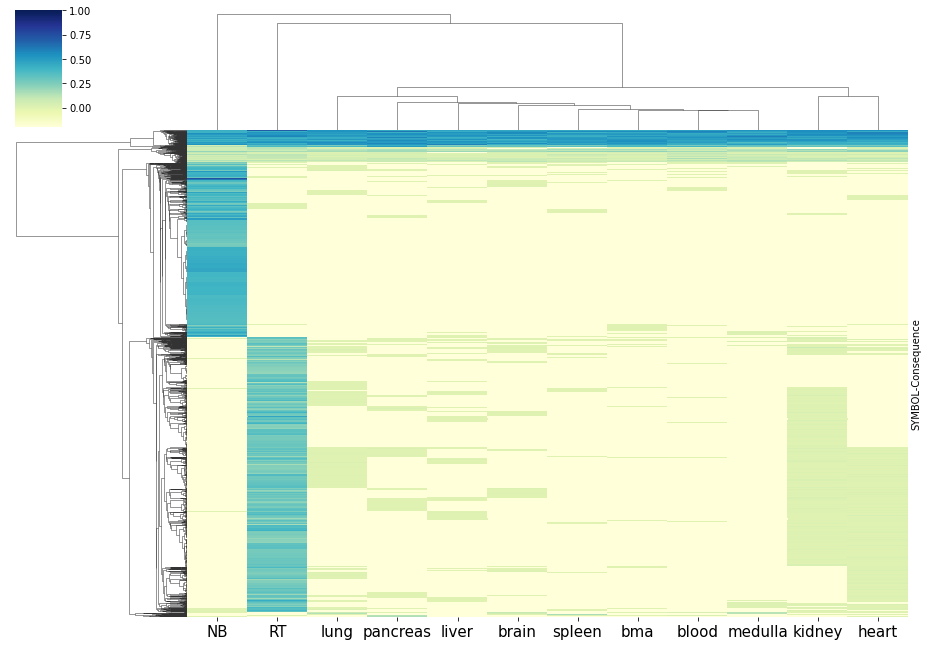

Present in at least 2 tissues


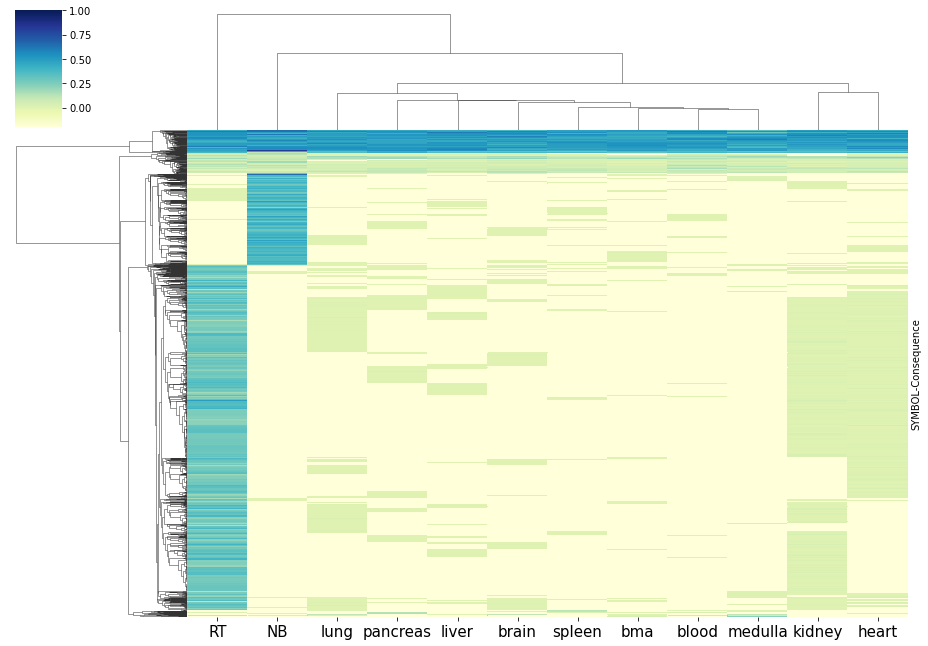

Present in at least 3 tissues


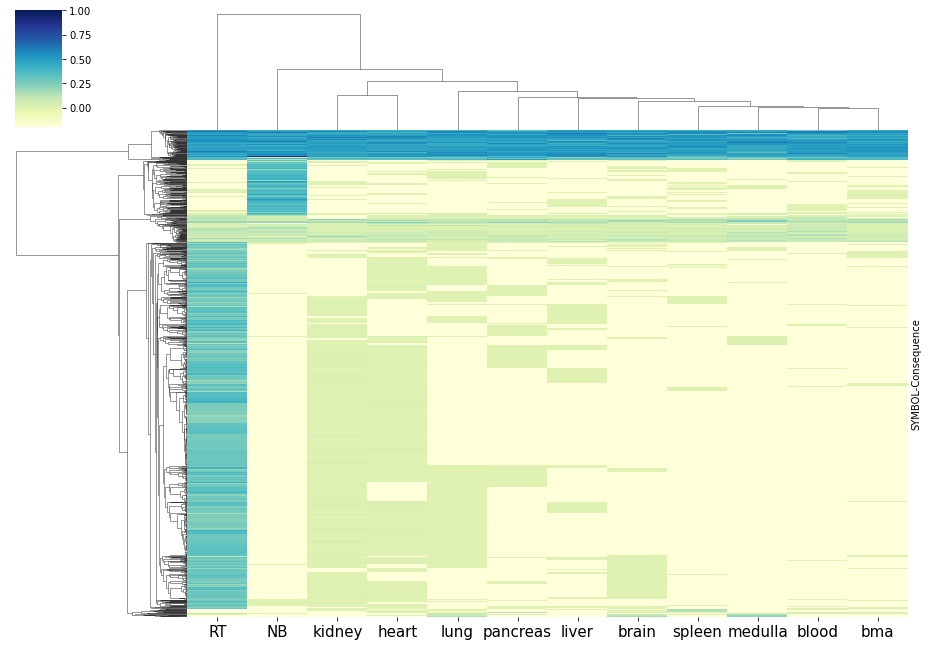

Present in at least 4 tissues


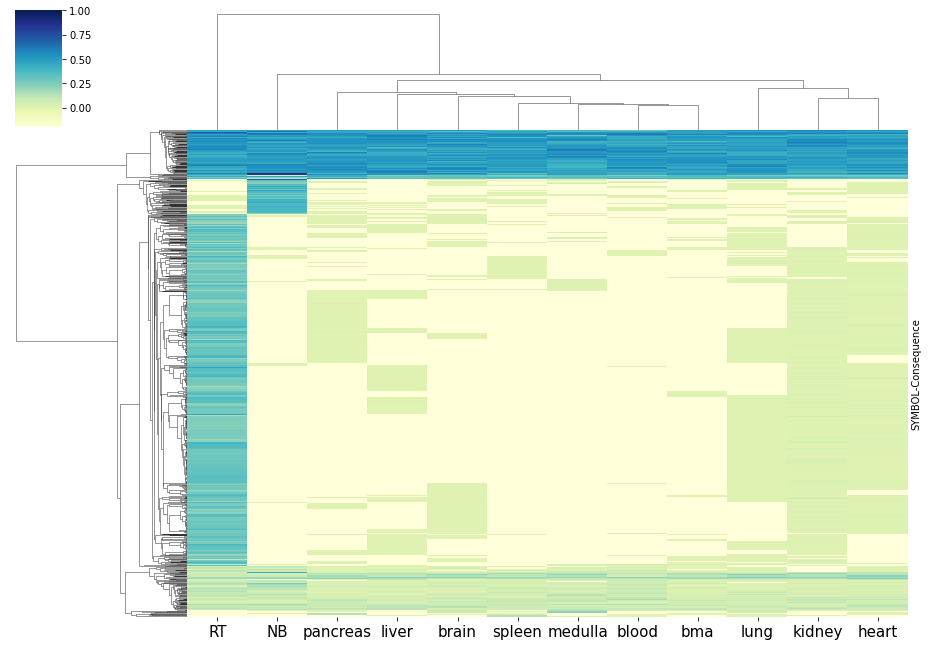

Present in at least 5 tissues


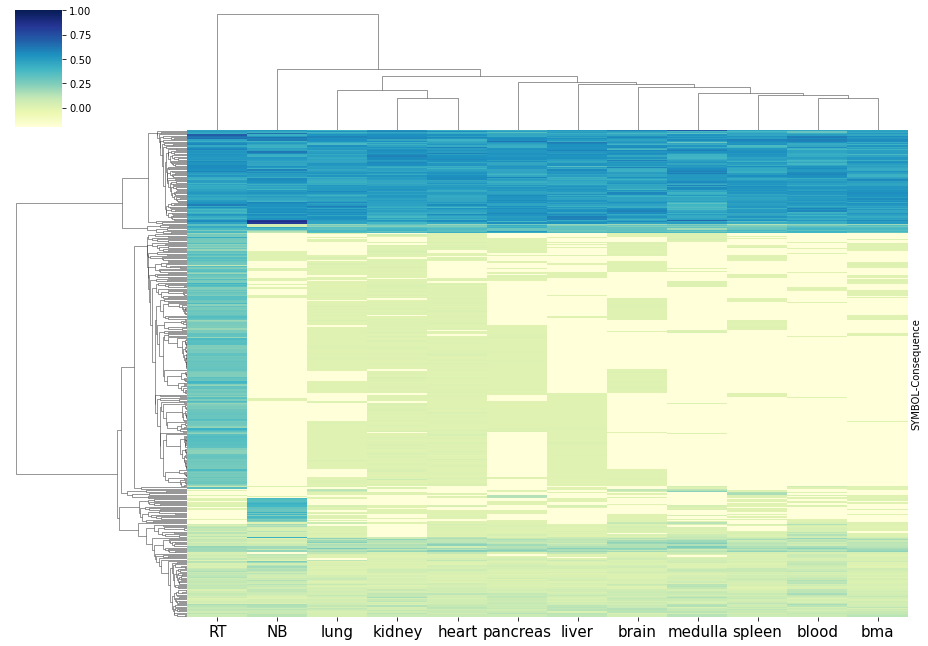

Present in at least 6 tissues


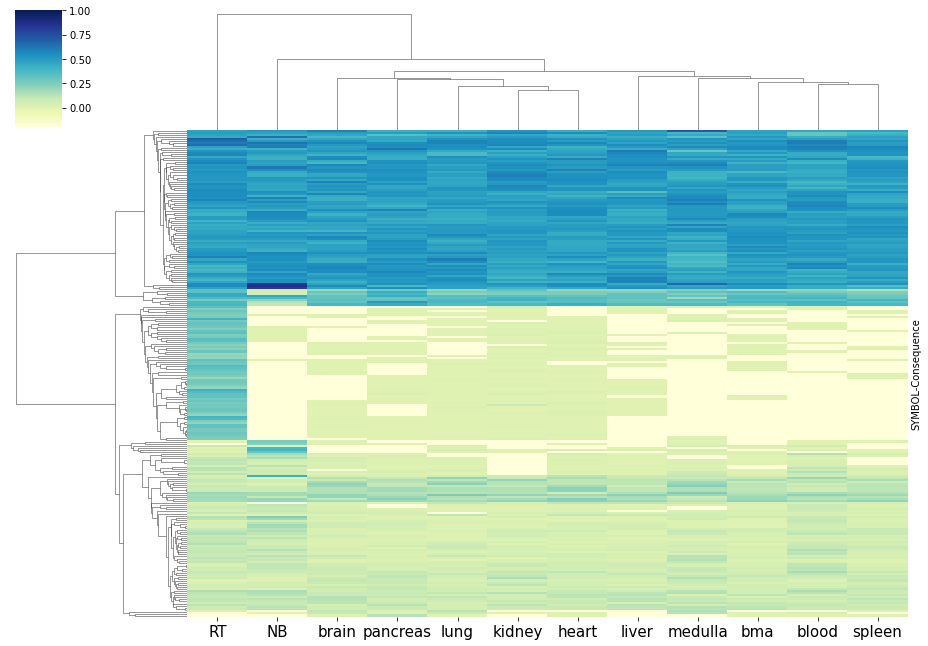

Present in at least 7 tissues


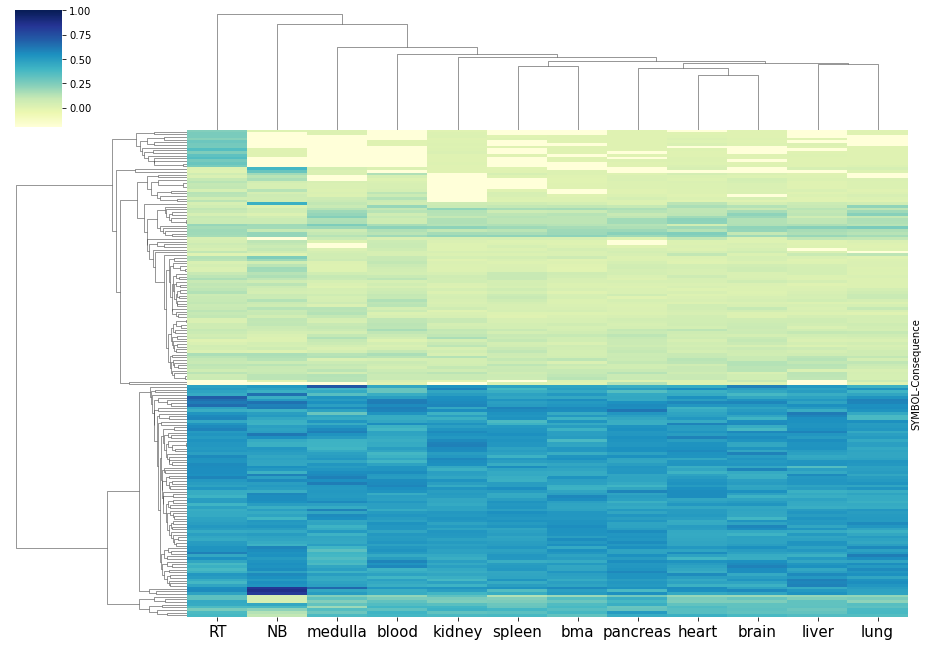

Present in at least 8 tissues


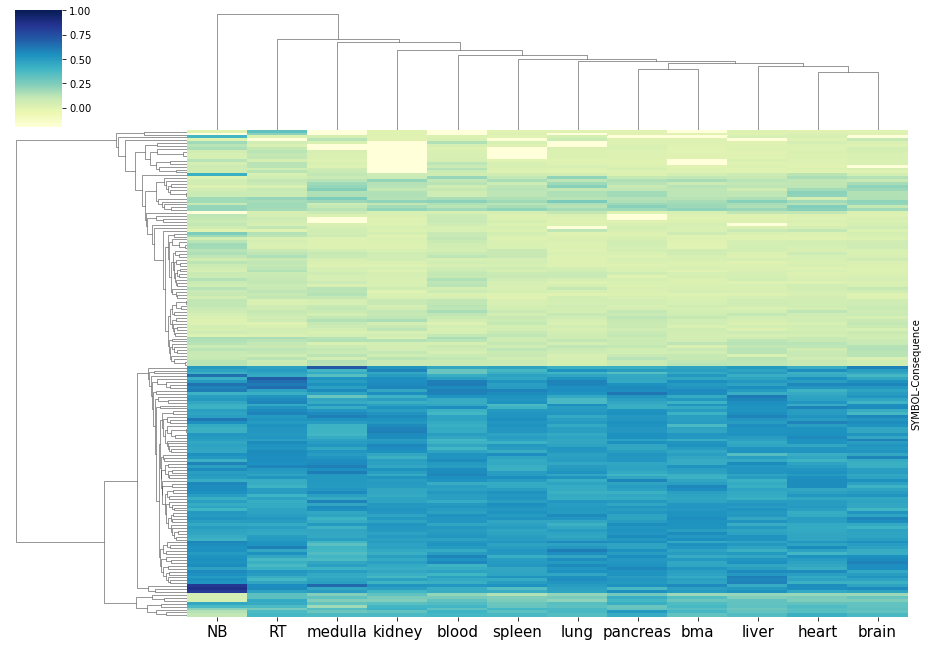

Present in at least 9 tissues


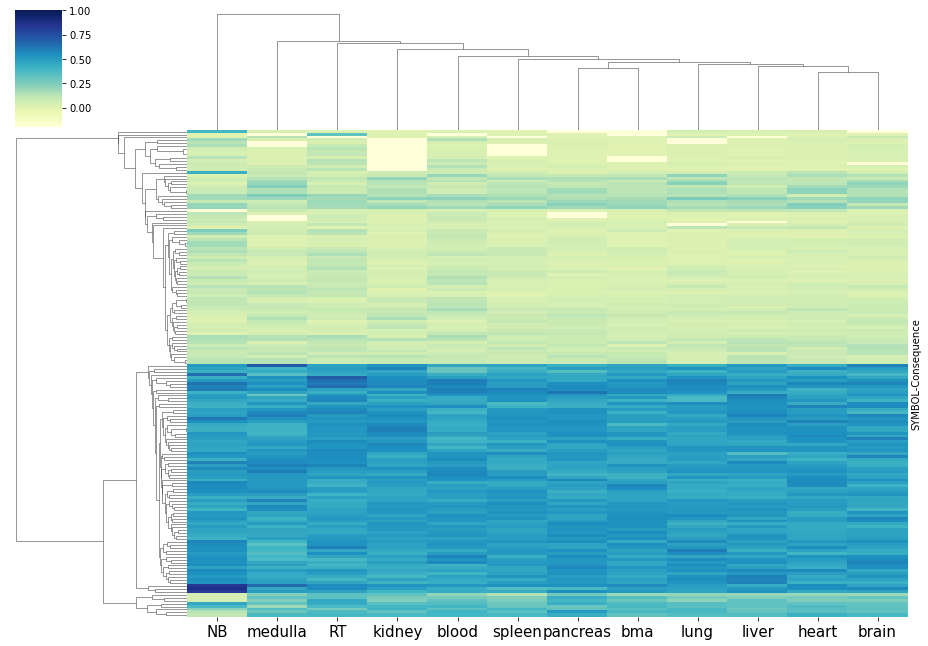

Present in at least 10 tissues


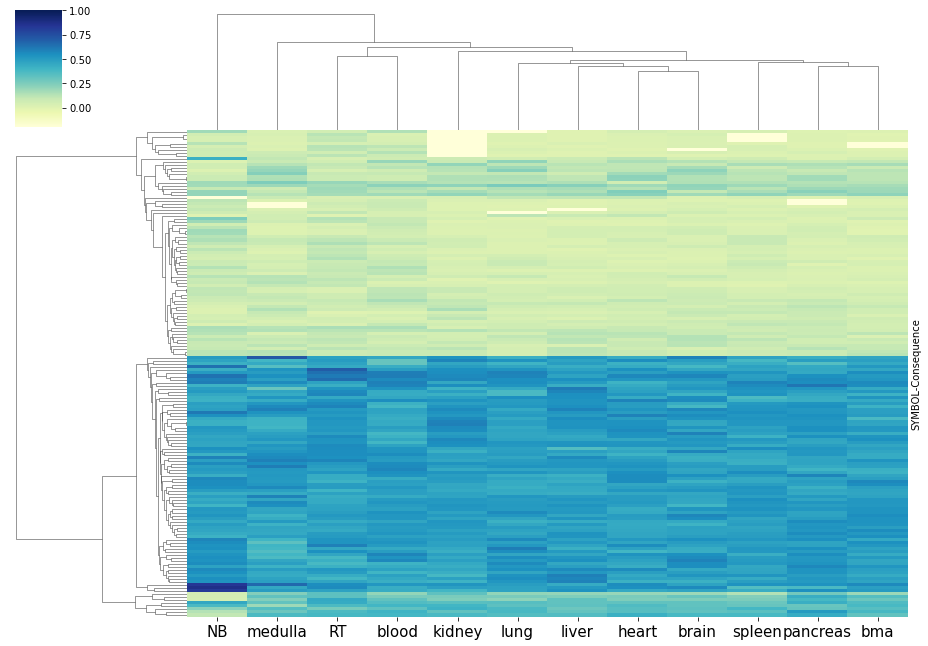

Present in at least 11 tissues


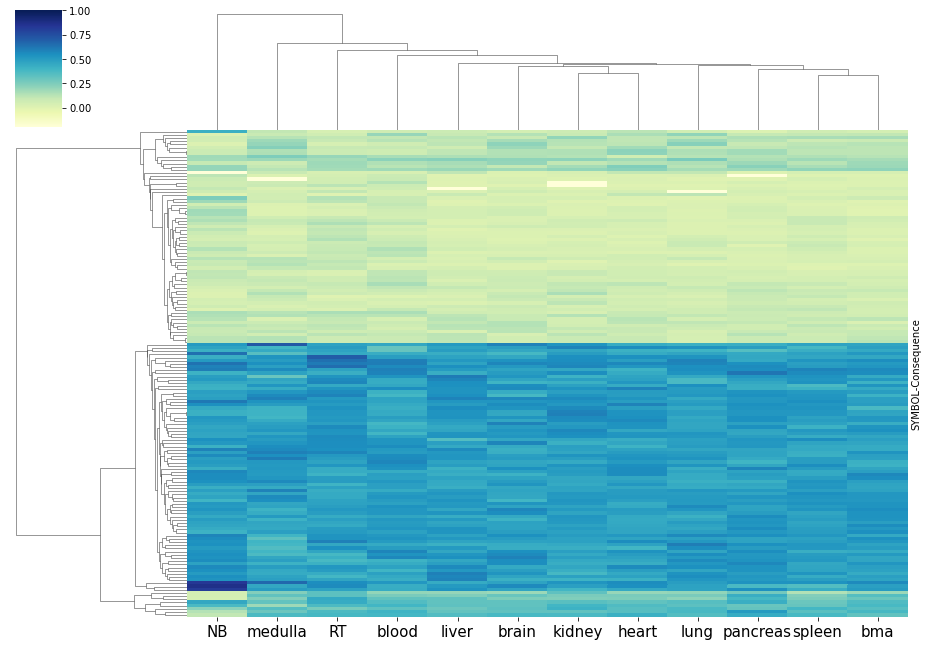

Present in at least 12 tissues


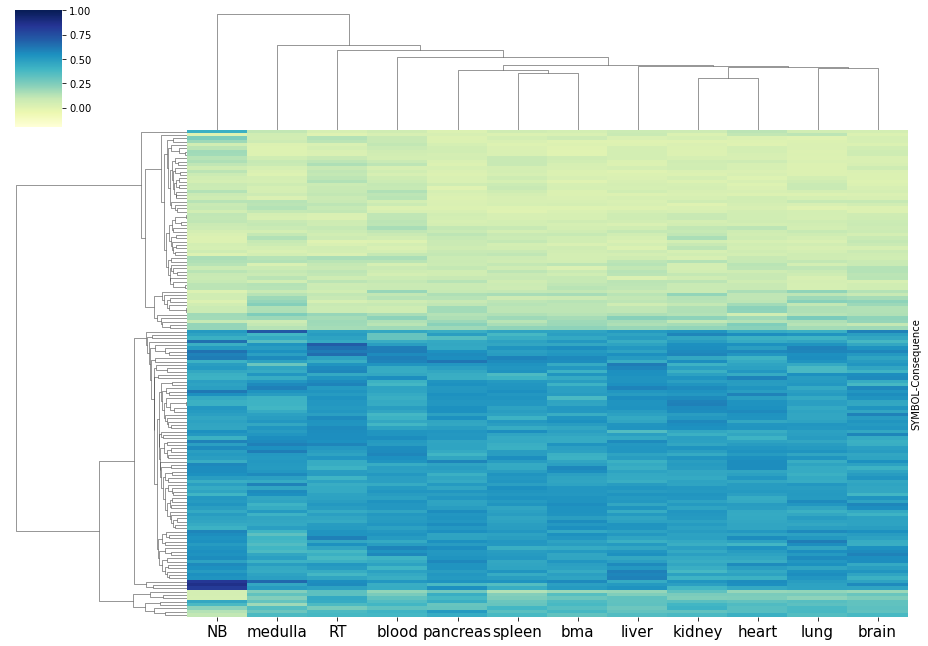

In [117]:
for n in range(1,len(tissues)+1):
    print('Present in at least',n, 'tissues')
    data = df[df['n_tissues']>=n].sort_values(by=af_cols,ascending=False)
    data = data.drop_duplicates(subset=['SYMBOL','#Uploaded_variation'])
    data = data.set_index(['SYMBOL','Consequence'])
    data.index_name = ''
    data[af_cols] = data[af_cols].replace(0,-0.2)
    if len(data) < 50:
        height = 5
        yticklabels = True
        n=5
    else:
        height = 9
        yticklabels = False
        n=1
    cg = sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+n),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
    ax = cg.ax_heatmap
    x_tick_labels = ax.get_xticklabels()
    new_labels = [label_cols_dict[label.get_text()] for label in x_tick_labels]
    ax.set_xticklabels(new_labels)
    plt.setp(ax.get_xticklabels(), fontsize=15)
    ax = cg.fig.gca()
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.show()

Present in only 1 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
22,chr1,33581127,C,A,False,snv,55.0,133.0,139.0,109.0,...,4.566971e-33,6.688628e-34,4.323837e-32,3.266377e-31,1.057526e-33,5.171054e-14,2.757268e-48,1.490609e-32,8.339995e-34,False
11,chr1,19841394,C,T,False,snv,54.0,118.0,112.0,130.0,...,2.177702e-39,1.594693e-40,1.258402e-42,9.968192e-36,1.652385e-35,1.262464e-17,1.378634e-48,5.822690e-35,3.106890e-42,False
42,chr1,69134329,A,C,False,snv,71.0,132.0,140.0,121.0,...,1.114983e-36,1.337726e-33,2.061766e-38,1.594911e-34,8.871174e-27,7.705471e-22,4.736951e-38,6.105533e-29,3.106890e-42,False
54,chr1,85172828,T,A,False,snv,75.0,135.0,147.0,144.0,...,1.329164e-43,1.216654e-45,6.443020e-40,2.492048e-36,1.290926e-37,3.082189e-21,1.129377e-44,6.105533e-29,2.545165e-38,False
41,chr1,68652305,C,A,False,snv,77.0,111.0,136.0,135.0,...,6.805317e-41,5.225491e-36,8.247065e-38,3.189821e-34,2.521339e-40,1.262464e-17,1.445603e-42,2.384974e-31,2.545165e-38,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,chr1,181997261,A,G,False,snv,113.0,129.0,125.0,130.0,...,2.177702e-39,1.306373e-36,8.247065e-38,3.987277e-35,2.017072e-39,3.082189e-21,1.764652e-46,1.421555e-38,7.953639e-40,False
634,chr14,90394334,AATGTTATATTTAGGTGAAATAAGGTT,-,False,indel,120.0,99.0,100.0,126.0,...,1.393729e-37,1.712289e-31,8.647675e-32,2.090481e-29,1.386121e-28,3.852736e-22,2.960594e-39,9.316304e-34,6.515621e-36,False
1169,chr20,46430974,C,T,False,snv,121.0,141.0,148.0,140.0,...,2.126662e-42,5.225491e-36,5.154416e-39,3.802564e-41,1.108897e-27,2.407960e-23,2.205815e-47,9.097953e-37,7.953639e-40,False
2138,chr9,29084423,G,A,False,snv,119.0,117.0,137.0,133.0,...,2.722127e-40,4.180393e-35,3.459070e-31,2.041486e-32,2.017072e-39,7.890403e-19,7.228013e-43,1.953771e-27,2.606248e-35,False


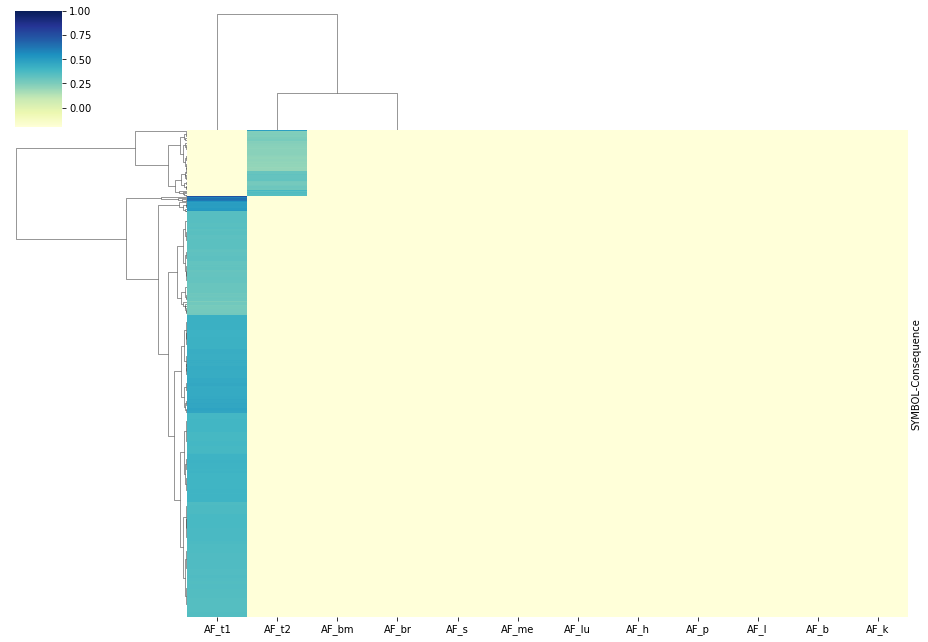

Present in only 2 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
52,chr1,82889119,C,A,False,snv,68.0,131.0,131.0,126.0,...,3.484322e-38,5.350903e-33,2.061766e-38,6.230120e-37,2.521339e-40,7.890403e-19,1.184238e-38,1.819591e-36,3.181456e-39,False
5,chr1,8139423,G,T,False,snv,52.0,151.0,122.0,121.0,...,1.114983e-36,9.966833e-42,1.288604e-39,6.230120e-37,5.414535e-31,1.615954e-15,1.129377e-44,7.278362e-36,7.184684e-42,False
27,chr1,44754299,C,A,False,snv,69.0,130.0,108.0,105.0,...,7.307154e-32,1.045098e-35,2.161919e-32,5.103714e-33,2.065481e-36,3.231909e-15,6.685912e-42,4.658152e-34,1.553445e-42,False
705,chr15,95765027,C,A,False,snv,111.0,118.0,139.0,108.0,...,9.133942e-33,8.164830e-38,4.026887e-41,2.492048e-36,4.130962e-36,3.945201e-19,3.907984e-37,6.105533e-29,6.213781e-42,False
1566,chr5,9399745,G,A,False,snv,114.0,124.0,122.0,127.0,...,1.742161e-38,8.164830e-38,1.610755e-40,3.090140e-34,1.538903e-44,8.273687e-13,5.782411e-42,1.110590e-40,5.090329e-38,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,chr3,6566697,T,G,False,snv,98.0,118.0,102.0,150.0,...,2.076818e-45,2.057537e-35,4.323837e-32,3.189821e-34,2.115053e-33,4.136843e-13,7.058607e-46,1.526383e-29,7.953639e-40,False
639,chr14,97637852,C,A,False,snv,116.0,111.0,160.0,125.0,...,6.968645e-38,3.367992e-37,6.597652e-37,2.492048e-36,6.454629e-38,7.524874e-25,1.515824e-36,8.884720e-40,1.896295e-46,False
2393,chr10,121309249,A,C,False,snv,99.0,140.0,118.0,118.0,...,8.919866e-36,3.187550e-34,4.123533e-38,2.433641e-39,2.115053e-33,9.863003e-20,1.199624e-25,3.553888e-39,1.018066e-37,False
2428,chr5,75515487,T,C,False,snv,126.0,114.0,149.0,145.0,...,6.645818e-44,2.140361e-32,8.444995e-35,3.042051e-40,4.230106e-33,6.210953e-07,3.446585e-49,2.274488e-37,2.235607e-31,False


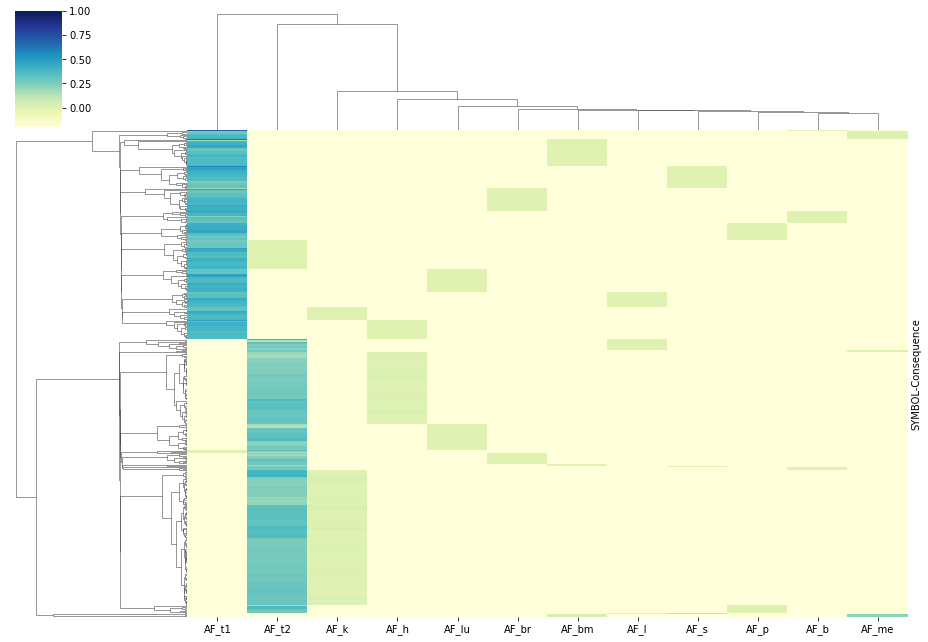

Present in only 3 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
2301,chrX,88690661,G,T,False,snv,118.0,121.0,152.0,114.0,...,1.641255e-32,3.893294e-44,3.298826e-37,7.974554e-35,1.652385e-35,6.164377e-21,3.614007e-43,7.453043e-33,5.090329e-38,False
774,chr16,87588273,G,T,False,snv,131.0,153.0,106.0,131.0,...,9.415293e-36,1.696754e-37,6.443020e-40,5.802251e-46,3.939593e-42,5.049858e-17,3.529303e-46,8.884720e-40,6.068145e-45,False
132,chr1,212640429,C,A,False,snv,113.0,105.0,135.0,122.0,...,5.574916e-37,9.966833e-42,8.647675e-32,4.867281e-39,5.998984e-32,1.972601e-19,2.312964e-41,1.355701e-44,9.942049e-41,False
147,chr1,232941629,A,T,False,snv,120.0,118.0,147.0,109.0,...,4.566971e-33,2.487334e-33,1.319530e-36,1.020743e-32,1.032741e-36,4.164037e-18,4.517508e-44,2.274488e-37,9.942049e-41,False
2053,chr8,84813128,G,T,False,snv,118.0,118.0,128.0,142.0,...,5.316654e-43,1.696754e-37,2.516805e-42,1.946913e-38,1.969796e-42,3.945201e-19,1.328147e-41,6.252066e-26,3.703702e-49,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,chr18,31466564,T,G,False,snv,117.0,135.0,134.0,129.0,...,4.355403e-39,1.092365e-38,1.055624e-35,3.189821e-34,4.924491e-43,2.465751e-20,1.258910e-29,1.669482e-30,4.740738e-47,False
2398,chr13,40404721,T,G,False,snv,124.0,122.0,141.0,131.0,...,1.088851e-39,4.983417e-42,2.702398e-33,2.680807e-39,1.321908e-34,1.881219e-25,1.144440e-21,4.997655e-40,6.068145e-45,False
258,chr10,119712878,ACATATATGTGTGCGTACATATATATATGTACGCACACATATATATAC,-,False,indel,118.0,120.0,103.0,104.0,...,1.870631e-29,8.561444e-32,2.901678e-24,4.180963e-29,1.212915e-13,6.518865e-10,3.031649e-36,3.908628e-17,1.042499e-34,False
1763,chr6,63674297,-,TA,False,indel,130.0,142.0,141.0,94.0,...,6.129685e-25,1.838556e-22,4.533872e-26,2.805797e-21,2.922836e-16,1.155539e-06,1.212659e-35,9.944630e-13,4.169998e-34,False


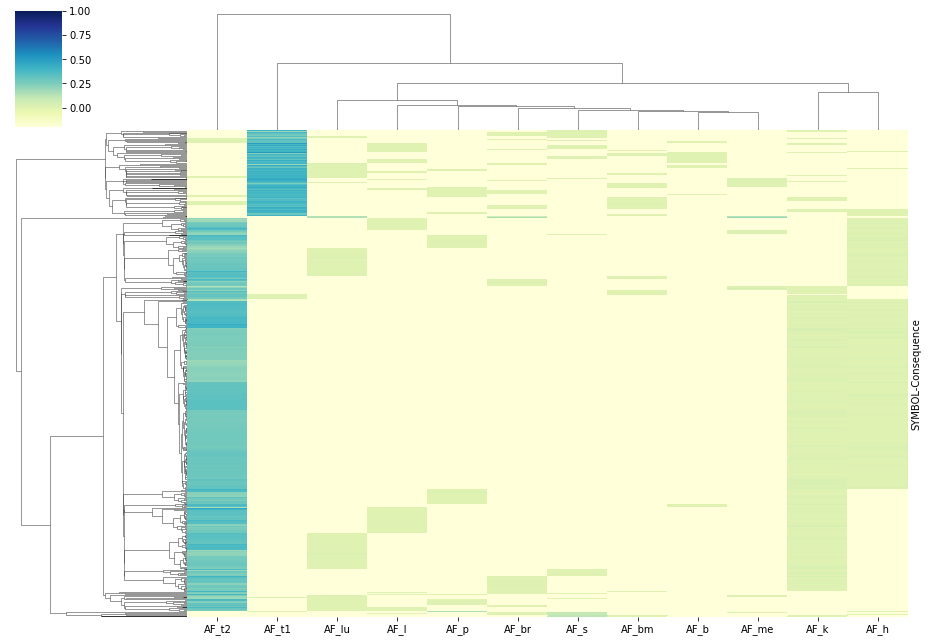

Present in only 4 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
44,chr1,69807254,G,T,False,snv,82.0,125.0,122.0,140.0,...,2.126662e-42,4.180393e-35,1.055624e-35,1.557530e-37,3.304770e-35,2.928079e-20,1.102907e-47,2.911345e-35,1.118480e-40,False
1103,chr2,205126900,C,A,False,snv,99.0,113.0,92.0,118.0,...,8.919866e-36,3.265932e-37,3.298826e-37,4.784732e-33,8.663256e-30,2.068422e-13,2.638225e-41,1.221107e-28,1.906307e-34,False
2140,chr9,29668152,G,T,False,snv,93.0,121.0,118.0,126.0,...,3.484322e-38,2.487334e-33,4.982547e-33,1.557530e-37,6.454629e-38,2.019943e-16,1.438949e-47,8.002644e-24,6.515621e-36,False
2313,chrX,96230400,C,A,False,snv,109.0,136.0,134.0,131.0,...,1.088851e-39,6.531864e-37,1.713843e-37,1.004607e-35,1.280598e-34,2.407960e-23,1.850371e-40,1.907979e-30,3.703702e-49,False
548,chr13,94747665,G,T,False,snv,129.0,116.0,122.0,119.0,...,4.459933e-36,7.973467e-41,2.767256e-30,2.551857e-33,2.707268e-31,2.585527e-14,8.878404e-46,4.658152e-34,9.942049e-41,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,chr2,157233309,A,-,False,indel,107.0,106.0,130.0,123.0,...,3.184838e-32,1.020604e-38,1.713843e-37,1.594911e-34,4.230106e-33,2.019943e-16,9.473902e-38,1.907979e-30,2.427258e-44,False
614,chr14,72657399,C,G,False,snv,105.0,117.0,114.0,123.0,...,3.456448e-35,7.973467e-41,8.247065e-38,8.274378e-38,2.869704e-29,2.465751e-20,7.401486e-40,5.962435e-32,3.034073e-45,False
947,chr2,11672881,T,-,False,indel,123.0,105.0,135.0,137.0,...,5.662024e-37,2.041207e-38,4.123533e-38,1.208534e-29,4.737718e-31,2.524929e-17,7.401486e-40,1.164538e-34,1.242756e-41,False
2181,chr9,101659778,T,G,False,snv,139.0,130.0,158.0,114.0,...,1.427178e-34,4.280722e-32,1.080959e-32,9.968192e-36,3.253133e-35,1.009972e-16,4.380599e-19,1.953771e-27,4.072263e-37,False


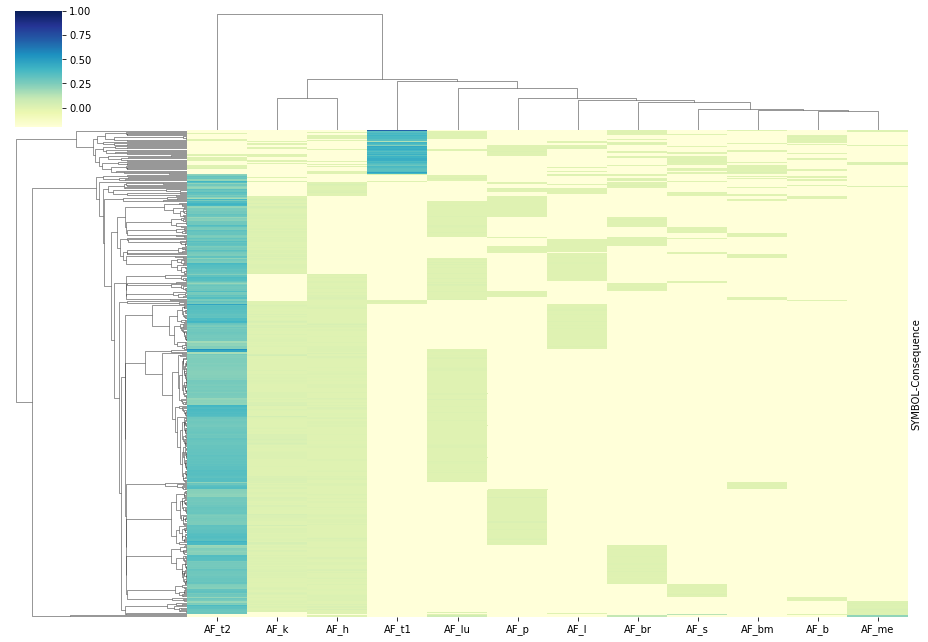

Present in only 5 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
589,chr14,45459132,G,T,False,snv,96.0,100.0,130.0,114.0,...,1.427178e-34,1.070181e-32,1.266749e-33,5.226203e-30,1.652385e-35,1.262464e-17,1.539509e-36,2.329076e-34,4.411784e-40,False
581,chr14,40533139,C,A,False,snv,131.0,108.0,123.0,122.0,...,4.183417e-33,3.344314e-34,2.356491e-30,2.266049e-30,9.390834e-31,4.039886e-16,1.241763e-32,1.953771e-27,1.303124e-35,False
2084,chr8,113618796,G,T,False,snv,125.0,116.0,151.0,104.0,...,1.461431e-31,6.531864e-37,1.340148e-36,3.802564e-41,3.384084e-32,1.578081e-18,2.752857e-44,2.142750e-31,3.034073e-45,False
1020,chr2,101928120,G,T,False,snv,116.0,120.0,138.0,125.0,...,6.968645e-38,4.180393e-35,2.111249e-35,2.717626e-28,7.694517e-45,2.465751e-20,6.044018e-46,2.748310e-32,8.761431e-40,False
1938,chr7,122900673,-,T,False,indel,105.0,133.0,114.0,124.0,...,2.283486e-33,2.090196e-35,1.688999e-34,3.853175e-24,2.231655e-26,1.972601e-19,5.240310e-41,1.856082e-25,5.212497e-35,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,chr6,15336800,G,C,False,snv,120.0,124.0,119.0,134.0,...,1.361063e-40,2.491708e-42,2.331328e-16,5.103714e-33,8.460211e-33,4.815920e-23,2.645170e-36,1.490609e-32,5.631239e-41,False
1831,chr6,144261246,T,G,False,snv,106.0,124.0,143.0,153.0,...,3.058634e-42,1.861481e-43,5.154416e-39,6.084102e-40,3.932676e-33,9.863003e-20,1.037448e-19,2.911345e-35,1.896295e-46,False
493,chr13,40404717,T,G,False,snv,124.0,120.0,136.0,126.0,...,4.425090e-36,2.491708e-42,1.351199e-33,1.876755e-37,1.982862e-33,1.881219e-25,3.335462e-16,1.266767e-40,1.517036e-45,False
14,chr1,21263361,A,-,False,indel,94.0,131.0,152.0,109.0,...,1.496505e-28,6.684954e-37,1.383628e-30,2.090481e-29,1.398742e-14,3.145462e-09,7.228013e-43,9.857965e-20,6.860014e-39,False


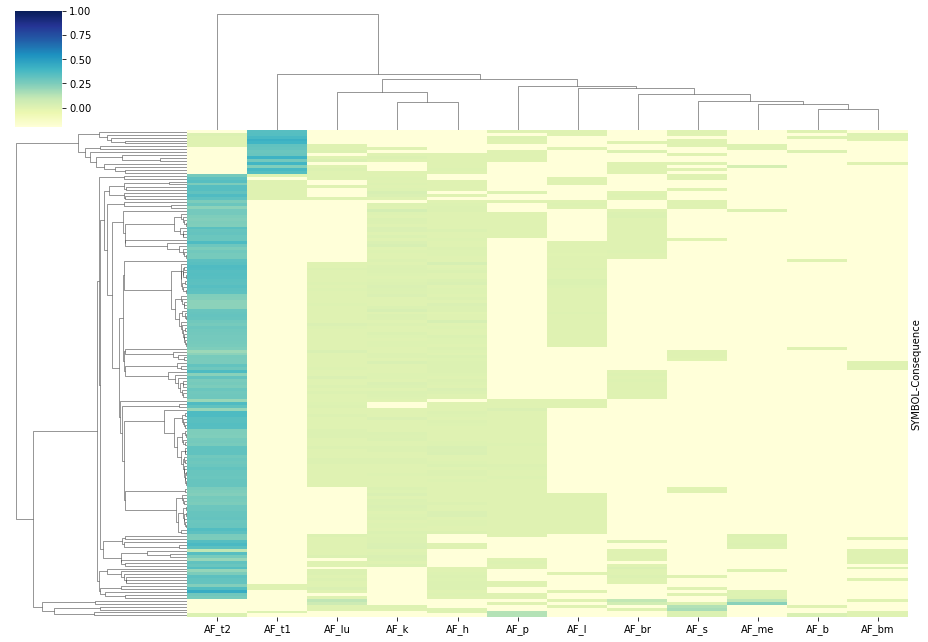

Present in only 6 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
831,chr18,1679683,C,A,False,snv,117.0,109.0,129.0,135.0,...,6.805317e-41,1.606838e-34,1.729535e-31,6.379643e-34,5.685262e-29,2.407960e-23,2.312964e-41,4.769948e-31,3.454862e-39,False
578,chr14,34374035,-,AG,False,indel,105.0,120.0,116.0,98.0,...,2.993010e-28,2.675451e-33,6.918140e-31,1.246024e-36,1.082907e-30,1.009972e-16,1.492329e-33,1.011229e-28,4.270077e-31,False
1724,chr6,10561174,-,T,False,indel,125.0,133.0,110.0,129.0,...,1.393729e-37,1.245854e-42,4.123533e-35,7.849951e-35,1.082907e-30,2.603833e-17,1.480297e-39,2.748310e-32,3.976820e-40,False
2426,chr4,116406189,C,G,False,snv,94.0,147.0,149.0,152.0,...,5.192045e-46,3.712935e-50,3.221510e-40,1.521025e-40,4.801261e-37,3.362850e-15,3.529303e-46,9.539895e-31,1.738368e-32,False
10,chr1,14864942,C,A,False,snv,88.0,127.0,136.0,137.0,...,2.347834e-39,4.752556e-48,2.639061e-36,2.550455e-36,6.454629e-38,3.945201e-19,2.258754e-44,7.392087e-36,2.427258e-44,False
1304,chr3,81334445,A,T,False,snv,101.0,129.0,134.0,118.0,...,6.263530e-32,4.383460e-29,2.061766e-38,3.960799e-31,7.309622e-30,7.890403e-19,4.466775e-46,3.052766e-29,3.106890e-42,False
2093,chr8,120342713,G,A,False,snv,108.0,141.0,123.0,138.0,...,3.727000e-36,3.265932e-37,4.427610e-29,8.580147e-31,2.097754e-36,1.321642e-17,1.480297e-39,3.726522e-33,3.976820e-40,False
487,chr13,36939458,A,C,False,snv,122.0,112.0,144.0,131.0,...,1.437283e-37,3.189387e-40,2.078260e-35,1.266116e-33,1.290926e-37,4.815920e-23,4.850638e-35,1.735297e-42,8.936861e-42,False
2258,chrX,40534860,G,T,False,snv,132.0,116.0,123.0,125.0,...,2.269172e-32,5.103019e-39,3.459070e-31,8.417476e-35,1.448388e-29,2.465751e-20,5.921188e-39,7.278362e-36,7.953639e-40,False
1715,chr6,1417595,G,T,False,snv,140.0,155.0,144.0,135.0,...,6.247962e-37,6.229271e-43,1.055624e-35,4.442554e-36,1.639476e-35,1.009972e-16,5.514537e-48,5.422803e-44,3.616614e-42,False


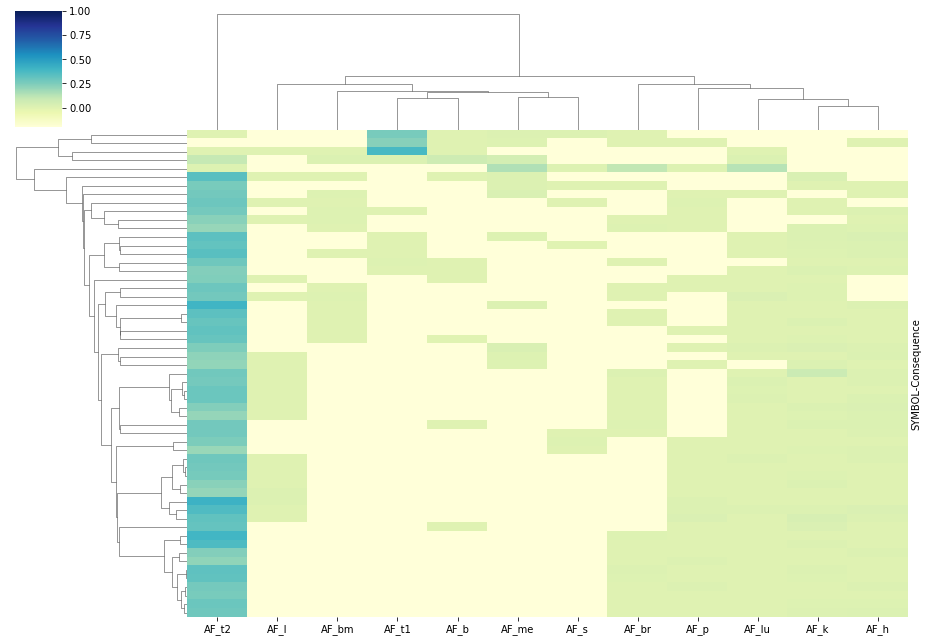

Present in only 7 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
469,chr12,121871199,-,A,False,indel,107.0,136.0,113.0,123.0,...,2.698259e-34,2.090196e-35,1.688999e-34,1.672385e-28,1.992211e-28,1.576231e-17,1.864464e-34,5.962435e-32,1.390903e-30,False
2147,chr9,36264142,-,T,False,indel,89.0,130.0,134.0,117.0,...,2.105088e-33,1.369831e-30,4.982547e-33,1.672385e-28,3.430649e-27,6.593094e-13,3.031649e-36,3.083294e-27,9.942049e-41,False
236,chr10,97467784,C,A,False,snv,97.0,103.0,113.0,114.0,...,9.356582e-31,1.672157e-34,4.982547e-33,1.100736e-35,9.390834e-31,3.156161e-18,3.529303e-46,2.981217e-32,5.631239e-41,False
1250,chr3,7316086,C,A,False,snv,129.0,103.0,145.0,113.0,...,6.866955e-29,2.332994e-30,1.080959e-32,2.412302e-33,2.097754e-36,2.465751e-20,2.757268e-48,1.526383e-29,5.090329e-35,False
1242,chr22,43283493,C,G,False,snv,120.0,133.0,107.0,144.0,...,1.927287e-41,7.026617e-40,5.033609e-42,2.492671e-33,9.996929e-34,5.049858e-17,7.058607e-46,6.377216e-41,2.958221e-44,False
1368,chr3,166157976,G,C,False,snv,113.0,125.0,112.0,130.0,...,1.854531e-35,1.254118e-33,2.296584e-41,3.265362e-34,1.448388e-29,1.504975e-24,4.736951e-38,6.105533e-27,2.036132e-37,False
1428,chr4,31007007,G,T,False,snv,126.0,126.0,128.0,131.0,...,9.415293e-36,8.360786e-35,3.632023e-29,2.834279e-36,5.414535e-31,2.351523e-26,2.312964e-41,5.777200e-35,1.739859e-39,False
2033,chr8,61918571,T,A,False,snv,105.0,134.0,150.0,115.0,...,4.760354e-31,9.530600e-28,3.026686e-31,6.764798e-24,1.321908e-34,9.631839e-23,1.850371e-40,1.437975e-24,7.767226e-43,False
1582,chr5,28294827,A,T,False,snv,101.0,135.0,129.0,121.0,...,1.360279e-34,3.845961e-32,3.832444e-32,2.745847e-26,2.230788e-28,1.232875e-20,2.368475e-38,2.911345e-35,3.768887e-45,False
909,chr19,14758985,A,G,False,snv,138.0,100.0,116.0,135.0,...,6.247962e-37,1.254118e-33,2.190627e-38,4.082971e-32,5.325069e-37,6.164377e-21,9.917991e-38,1.819591e-36,3.768887e-45,False


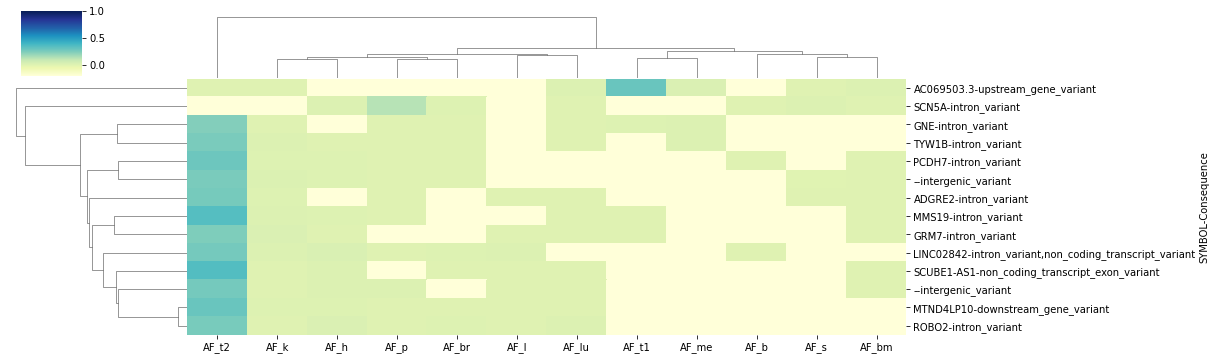

Present in only 8 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
2290,chrX,80521419,G,C,False,snv,111.0,141.0,124.0,125.0,...,8.780493e-36,1.606838e-34,1.623022e-34,1.120265e-29,8.261925e-36,6.463818e-15,1.912894e-39,1.607424e-35,1.427228e-41,False


No mutations found
Present in only 9 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
2014,chr8,42908845,A,G,False,snv,109.0,130.0,147.0,131.0,...,1.437283e-37,5.423625e-28,1.258402e-42,2.209214e-33,3.140696e-32,9.462960e-15,7.237829e-48,9.097953e-37,4.854516e-44,False
695,chr15,91177876,C,T,False,snv,114.0,146.0,140.0,151.0,...,1.038409e-45,1.279359e-34,4.402337e-31,3.700275e-37,4.696379e-34,1.469702e-27,9.251857e-41,1.455226e-25,3.912035e-48,False
2409,chr2,58116438,A,T,False,snv,144.0,136.0,152.0,165.0,...,6.337946e-50,1.087786e-40,7.109840e-39,1.275705e-34,1.652385e-35,1.232875e-20,3.596029e-44,8.157061e-36,4.199521e-37,False
2415,chr22,23840741,C,A,False,snv,108.0,77.0,112.0,134.0,...,1.837436e-38,2.433309e-45,7.538214e-32,1.246531e-28,3.052547e-26,4.957144e-09,8.823258e-47,8.906275e-24,8.146563e-34,False
1723,chr6,7307024,T,A,False,snv,114.0,123.0,119.0,131.0,...,1.437283e-37,1.685425e-34,4.123533e-35,9.489719e-33,4.380827e-39,3.945201e-19,3.055333e-36,1.299811e-29,3.792591e-46,False


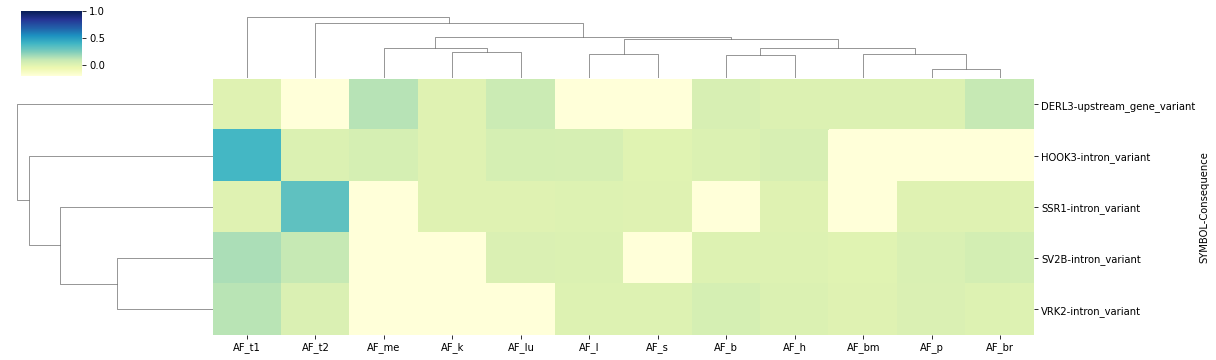

Present in only 10 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
1533,chr4,156605266,A,G,False,snv,122.0,120.0,119.0,96.0,...,3.741263e-29,1.095865e-27,1.559652e-23,2.773594e-25,1.108897e-27,8.466402e-16,6.527140e-30,6.616096e-27,1.390903e-30,False
2259,chrX,41800652,C,T,False,snv,135.0,137.0,157.0,133.0,...,2.722127e-40,4.706795e-25,7.701835e-32,1.246531e-28,1.280598e-34,1.151368e-14,2.516505e-38,1.350498e-24,8.144526e-37,False
2422,chr3,130129075,C,G,False,snv,142.0,163.0,160.0,152.0,...,6.037829e-42,7.026617e-40,3.221510e-40,4.906843e-33,2.314842e-36,1.009972e-16,3.523570e-37,6.226796e-33,9.162899e-43,False
2413,chr2,131321269,G,C,False,snv,117.0,129.0,147.0,127.0,...,1.742161e-38,1.394161e-32,5.370918e-32,4.784732e-33,6.490644e-31,1.009972e-16,4.827310e-33,4.769948e-31,3.454862e-39,False
2418,chr3,125780713,A,G,False,snv,138.0,154.0,154.0,145.0,...,6.645818e-44,5.501692e-39,4.352213e-30,5.550160e-36,2.955220e-33,7.335031e-18,5.782411e-42,1.236022e-27,2.414814e-46,False
1289,chr3,65003270,AT,-,False,indel,116.0,118.0,148.0,133.0,...,6.968645e-38,1.696754e-37,8.181089e-35,1.643906e-29,3.911325e-28,2.247778e-16,2.962684e-32,9.255484e-28,5.212497e-35,False
2420,chr3,125780746,G,A,False,snv,125.0,140.0,142.0,144.0,...,1.329164e-43,5.501692e-39,3.300169e-29,2.268866e-36,3.204057e-31,1.484266e-19,1.807003e-43,1.252974e-30,1.168118e-43,False
2419,chr3,125780741,G,A,False,snv,126.0,143.0,142.0,142.0,...,5.316654e-43,1.092365e-38,8.551740e-30,5.915185e-37,6.253121e-31,2.139039e-18,3.614007e-43,6.463678e-31,1.488592e-44,False


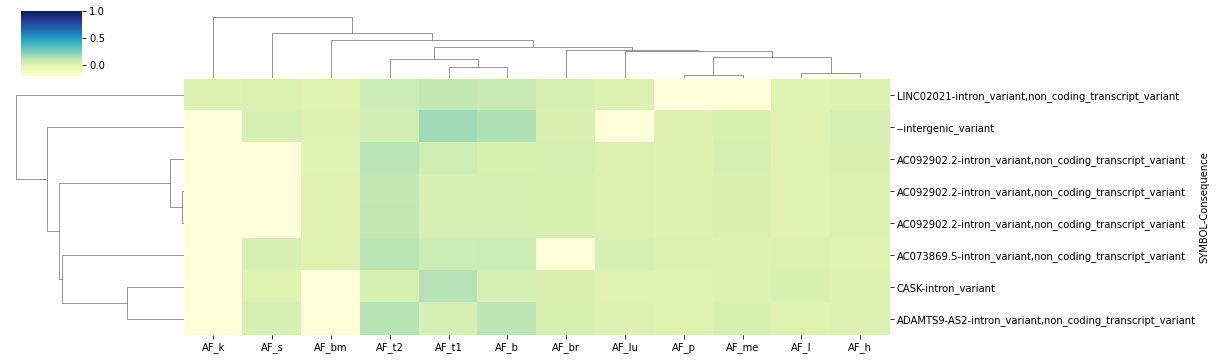

Present in only 11 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
2408,chr19,43043069,G,A,False,snv,146.0,138.0,119.0,152.0,...,1.140146e-38,8.099511e-35,4.323837e-32,3.648436e-33,1.306151e-28,1.999811e-20,2.490728e-40,2.099904e-36,1.041973e-39,False
2430,chr6,60921102,C,T,False,snv,140.0,135.0,157.0,128.0,...,7.192513e-35,2.140361e-32,3.029579e-34,2.164932e-30,8.988071e-36,3.902099e-20,6.900353e-37,2.864264e-25,1.176937e-30,False
2401,chr14,84501420,T,G,False,snv,135.0,162.0,163.0,138.0,...,8.159575e-38,9.698725e-38,2.296584e-41,2.100520e-35,1.418253e-40,9.863003e-20,1.209632e-32,9.113421e-30,5.564068e-36,False
2208,chrX,1298368,C,T,False,snv,140.0,164.0,141.0,115.0,...,5.114234e-28,5.769817e-34,4.981268e-26,6.822659e-24,8.068286e-39,1.186666e-20,2.849204e-38,6.123299e-22,2.039593e-30,False
2423,chr3,171627914,A,T,False,snv,129.0,139.0,128.0,120.0,...,2.229966e-36,2.770780e-39,6.939037e-25,9.545177e-34,1.128376e-32,2.230971e-11,7.626594e-41,3.445799e-25,8.881170e-40,False
1521,chr4,143879285,C,T,False,snv,131.0,145.0,145.0,126.0,...,3.484322e-38,1.696754e-37,3.832444e-32,8.274378e-38,2.097754e-36,1.087593e-11,1.467865e-38,3.522727e-33,8.881170e-40,False
628,chr14,86633941,C,G,False,snv,107.0,108.0,112.0,121.0,...,2.314520e-28,7.660451e-21,5.567447e-41,6.312838e-18,2.027458e-19,1.983734e-11,5.737215e-37,5.784024e-31,1.661529e-32,False


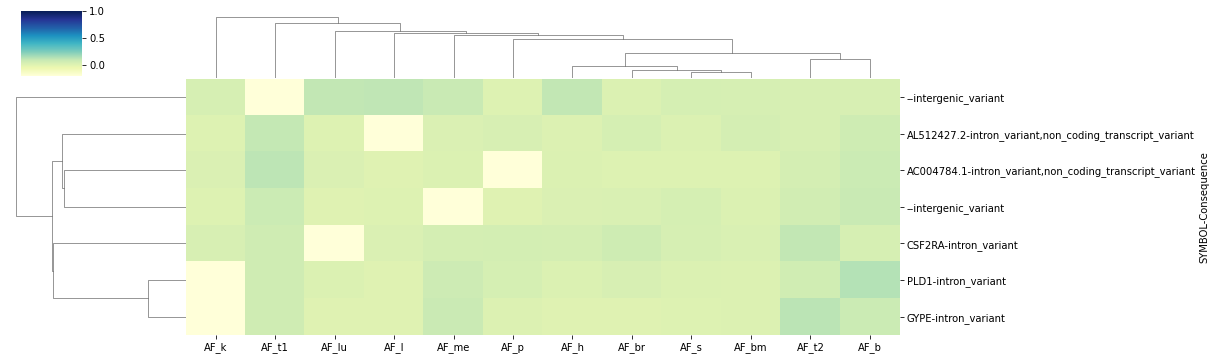

Present in only 12 tissues


,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
45,chr1,70221835,C,T,False,snv,73.0,138.0,126.0,128.0,...,1.000000e+00,1.000000e+00,1.993486e-02,1.000000e+00,1.000000e+00,1.000000e+00,2.578328e-03,1.000000e+00,1.000000e+00,True
59,chr1,88873475,G,C,False,snv,49.0,127.0,136.0,127.0,...,1.000000e+00,8.303398e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,True
24,chr1,36833949,A,G,False,snv,69.0,137.0,134.0,143.0,...,2.799793e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.643886e-01,1.000000e+00,1.000000e+00,True
955,chr2,18476813,G,A,False,snv,110.0,133.0,119.0,124.0,...,1.000000e+00,4.583530e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.296855e-02,1.000000e+00,2.899405e-01,1.000000e+00,True
2247,chrX,33524423,G,T,False,snv,114.0,101.0,115.0,124.0,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,chr1,57502335,A,G,False,snv,51.0,111.0,97.0,108.0,...,3.075836e-13,4.780430e-24,3.487098e-16,4.878025e-21,1.307274e-21,4.445369e-08,4.642177e-25,2.249479e-19,1.913096e-27,False
622,chr14,81274666,T,G,False,snv,103.0,137.0,130.0,131.0,...,1.286590e-28,1.700234e-26,3.378345e-22,1.078429e-27,2.586241e-30,9.664937e-11,4.898188e-24,2.754536e-15,7.634137e-30,False
775,chr17,2810266,G,A,False,snv,113.0,146.0,132.0,139.0,...,1.870219e-28,9.438964e-31,2.159567e-17,6.036838e-29,2.732784e-23,3.362850e-15,6.473664e-20,5.274872e-19,8.001808e-24,False
1442,chr4,47769076,G,C,False,snv,115.0,128.0,115.0,141.0,...,9.337717e-25,1.327246e-19,2.025903e-19,7.415936e-15,2.429969e-10,3.613080e-11,1.118912e-22,9.285136e-13,1.240705e-20,False


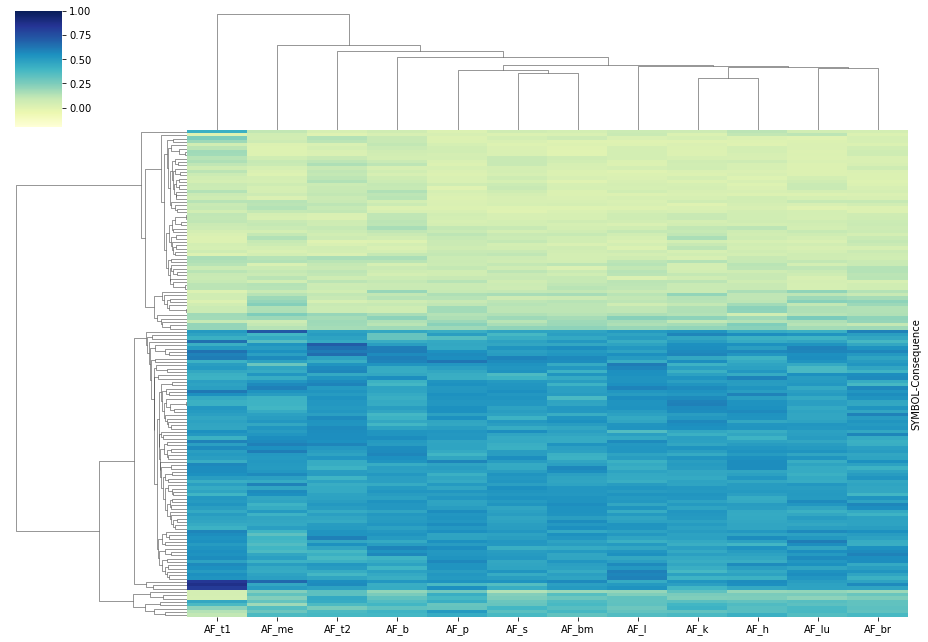

In [118]:
for n in range(1,len(tissues)+1):
    print('Present in only',n, 'tissues')
    data = df[df['n_tissues']==n].sort_values(by=af_cols,ascending=False)
    display(data)
    if len(data) <= 1:
        print('No mutations found')
    else:
        data = data.drop_duplicates(subset=['SYMBOL','#Uploaded_variation'])
        data = data.set_index(['SYMBOL','Consequence'])
        data[af_cols] = data[af_cols].replace(0,-0.2)
        if len(data) < 50:
            height = 5
            yticklabels = True
            n = 5
        else:
            height = 9
            yticklabels = False
            n = 1
        sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+n),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
        plt.show()

In [119]:
df[df['n_tissues']==len(tissues)].groupby('CHROM').count()

,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,...,qval_k,qval_l,qval_p,qval_h,qval_lu,qval_me,qval_s,qval_br,qval_bm,denovo_germline
CHROM,,,,,,,,,,,,,,,,,,,,,
chr1,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
chr10,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
chr11,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
chr12,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
chr13,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
chr14,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
chr15,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
chr16,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
chr17,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


### Present in 12 tissues, clonal in all

In [120]:
df = filt_denovo_df[(filt_denovo_df['denovo_germline']==True)]
print(len(df))

79


Present in only 12 tissues


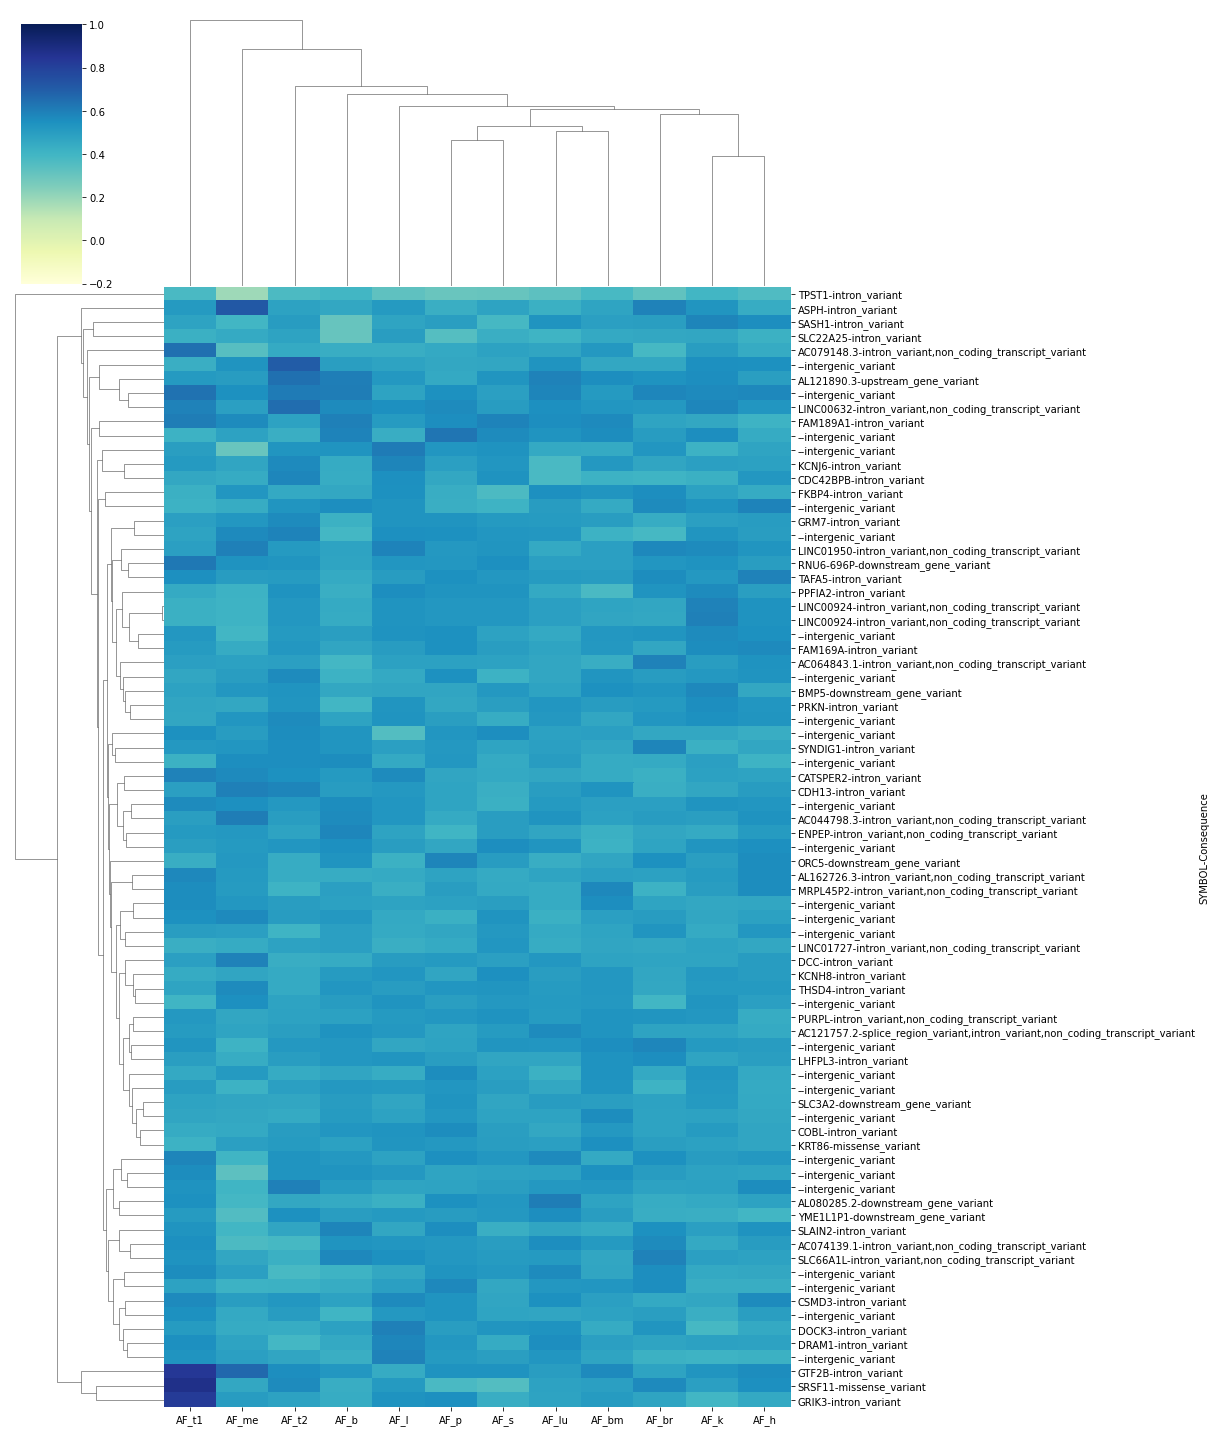

In [121]:
n=len(tissues)
print('Present in only',n, 'tissues')
data = df[df['n_tissues']==n].sort_values(by=af_cols,ascending=False)
data = data.drop_duplicates(subset=['SYMBOL','#Uploaded_variation'])
data = data.set_index(['SYMBOL','Consequence'])
data[af_cols] = data[af_cols].replace(0,-0.2)

height = 20
yticklabels = True
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+5),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

In [122]:
df['Consequence'].unique()

array(['intron_variant', 'missense_variant', 'intergenic_variant',
       'downstream_gene_variant',
       'splice_region_variant,intron_variant,non_coding_transcript_variant',
       'intron_variant,non_coding_transcript_variant',
       'upstream_gene_variant'], dtype=object)

In [123]:
DAMAGING_CONSEQ= ['transcript_ablation',
'splice_acceptor_variant',
'splice_donor_variant',
'stop_gained',
'frameshift_variant',
'stop_lost',
'start_lost',
'transcript_amplification',
'inframe_insertion',
'inframe_deletion',
'missense_variant',
'protein_altering_variant',
'splice_region_variant',
'incomplete_terminal_codon_variant',
'start_retained_variant',
'stop_retained_variant',
'synonymous_variant',
'coding_sequence_variant',
'mature_miRNA_variant',
'5_prime_UTR_variant',
'3_prime_UTR_variant',
'non_coding_transcript_exon_variant',
'intron_variant',
'NMD_transcript_variant',
'non_coding_transcript_variant',
'upstream_gene_variant',
'downstream_gene_variant',
'TFBS_ablation',
'TFBS_amplification',
'TF_binding_site_variant',
'regulatory_region_ablation',
'regulatory_region_amplification',
'feature_elongation',
'regulatory_region_variant',
'feature_truncation',
'intergenic_variant'
]
df['Consequence'] = df['Consequence'].astype("category")
df['Consequence'] = df['Consequence'].cat.set_categories(DAMAGING_CONSEQ)
df[['SYMBOL','Consequence','Amino_acids']][(~df['Consequence'].isnull())].sort_values(by= 'Consequence')

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SYMBOL,Consequence,Amino_acids
45,SRSF11,missense_variant,P/S
413,KRT86,missense_variant,M/V
24,GRIK3,intron_variant,-
1211,KCNJ6,intron_variant,-
1259,KCNH8,intron_variant,-
...,...,...,...
1281,-,intergenic_variant,-
969,-,intergenic_variant,-
2306,-,intergenic_variant,-
1234,-,intergenic_variant,-


### Present in all tissues, all variants

In [124]:
df = filt_denovo2_df

Present in all 12 tissues


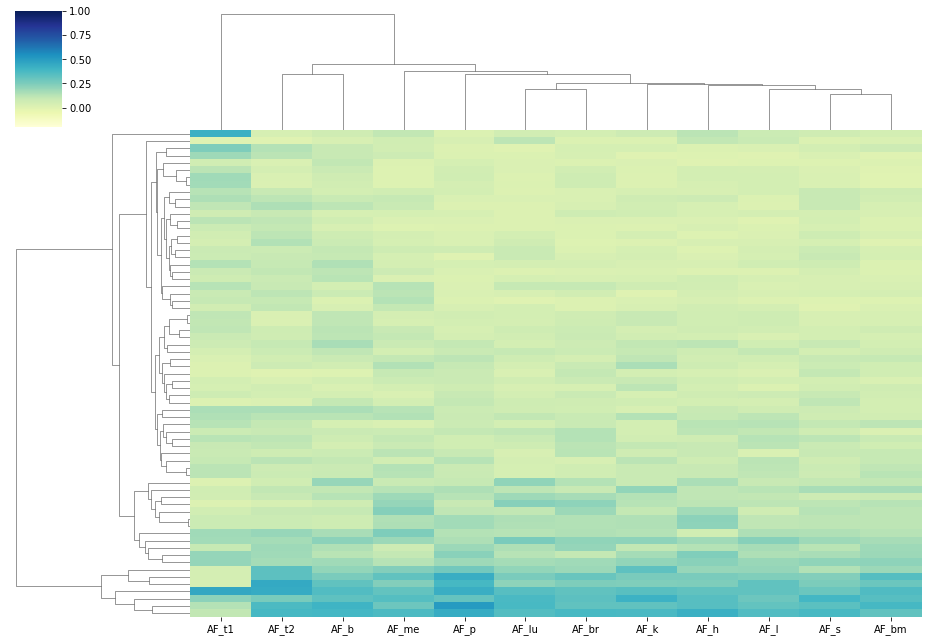

In [125]:
n=len(tissues)
print('Present in all',n, 'tissues')
data = df[df['n_tissues']==n].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
if len(data) < 50:
    height = 5
    yticklabels = True
else:
    height = 9
    yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

In [126]:
pd.set_option('display.max_columns', 500)

## Number of mutions per step

In [128]:
summary_all_filters_dict = {'haplotypecaller':len(hc3_df),
                       'mutect (tumor only mode)':len(mutect2_df),
                       'haplotypecaller and mutect':len(tissues2_df),
                       'somatic preliminar: without parents muts':len(somatic3_df),
                       'somatic without low mappability muts':len(filt_depth_df),
                       'somatic with muts rescued from bams':len(filt_rescued_df),
                       'somatic without muts present at parents bams':len(filt_parents_df),
                        'somatic without muts not found in any bam':len(filt_no_zeros_df),
                        'somatic without artifacts':len(filt_artifacts_df),
                       'somatic without de novo in NB or RT':len(filt_denovo2_df)
                      }
summary_all_filters_dict

{'haplotypecaller': 6204364,
 'mutect (tumor only mode)': 8071153,
 'haplotypecaller and mutect': 9738829,
 'somatic preliminar: without parents muts': 5456307,
 'somatic without low mappability muts': 2594163,
 'somatic with muts rescued from bams': 2594163,
 'somatic without muts present at parents bams': 1122915,
 'somatic without muts not found in any bam': 655494,
 'somatic without artifacts': 2438,
 'somatic without de novo in NB or RT': 2359}

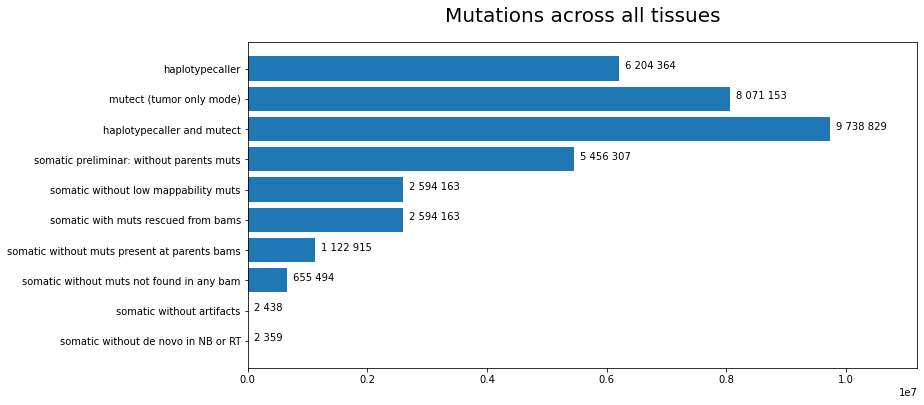

In [132]:
keys = list(summary_all_filters_dict.keys())
keys.reverse()
values = list(summary_all_filters_dict.values())
values.reverse()

fig, ax = plt.subplots(figsize=(12,6)) 
plt.barh(keys,values)  
plt.title('Mutations across all tissues',pad=20,size=20)
plt.xlim(0,summary_all_filters_dict['haplotypecaller and mutect']*1.15)
for i, v in enumerate(values):
    plt.text( v+100000, i, "{:,}".format(v).replace(',', ' '))
plt.savefig('./figures_paper/number_muts_vcf_processing.png',dpi=300, format='png')